# Libraries and Spark Session Initialization

In [ ]:
! pip install pyspark >& /dev/null

In [ ]:
import os
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, character_length, lower, trim, create_map, lit, to_date, sum
from itertools import chain
from pyspark.sql import functions as fn
from pyspark.sql.types import StructField, StringType, IntegerType, DoubleType
from pyspark.sql import DataFrame as d
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
spark = SparkSession.builder.appName('Final-Project').getOrCreate()

In [ ]:
drive.mount('/content/drive')

!ls /content/drive/MyDrive/BDA_FinalProject_DataSets

Mounted at /content/drive
building_permits			       Metro_median_sale_price_uc_sfrcondo_sm_sa_month.csv
building_permits_state_merge_results.csv       Neighborhood_housing_values_sa_month.csv
failed_banks				       rf_data
final_zillow_merge.csv			       unpiv_market_temp.csv
merged_dataset.csv			       unpiv_med_daystoclose.csv
Metro_market_temp_index_uc_sfrcondo_month.csv  unpiv_med_daystopending.csv
Metro_median_days_to_close_month.csv	       unpiv_mediansale.csv
Metro_median_days_to_pending_month.csv	       unpiv_nh_values.csv


# Data Ingestion 1.1

### No need to run this part every session. Just need to run it once. This was done to unpivot datasets from zillow and transform them into spark dataframes we will be able to use. The unpivoted datasets were then saved as csv files in the google drive. Therefore, this whole section can be skipped.

- Look at 'Data Ingestion 1.2' to ingest unpivoted csv files into spark session. The .ipynb file can being its session from this section onward.


In [ ]:
data_path = '/content/drive/MyDrive/BDA_FinalProject_DataSets/'
median_daystoclose = spark.read.csv(data_path+'Metro_median_days_to_close_month.csv', header = True)
median_daystopending = spark.read.csv(data_path+'Metro_median_days_to_pending_month.csv', header = True)
nh_values = spark.read.csv(data_path+'Neighborhood_housing_values_sa_month.csv', header = True) # nh = neighborhood housing
market_temp_index = spark.read.csv(data_path+'Metro_market_temp_index_uc_sfrcondo_month.csv', header = True)
median_saleprice = spark.read.csv(data_path + 'Metro_median_sale_price_uc_sfrcondo_sm_sa_month.csv', header = True)

In [ ]:
print(f'Size of median_daystoclose dataset {median_daystoclose.count()}, {len(median_daystoclose.columns)}')
median_daystoclose.show(10)

Size of median_daystoclose dataset 624, 83
+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|RegionID|SizeRank|      RegionName|Regio

In [ ]:
median_daystoclose.count()

624

In [ ]:
value_counts = median_daystoclose.groupBy("RegionName").count()

In [ ]:
static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
date_columns = [col for col in median_daystoclose.columns if col not in static_columns]
static_df = median_daystoclose.select(static_columns + date_columns).collect()

daystoclose_dict_list = []

for row in static_df:
    for col in date_columns:
        daystoclose_dict = {
            'RegionID': row['RegionID'],
            'SizeRank': row['SizeRank'],
            'RegionName': row['RegionName'],
            'RegionType': row['RegionType'],
            'StateName': row['StateName'],
            'Date': col,
            'Median Days To Close': row[col]
        }
        daystoclose_dict_list.append(daystoclose_dict)

unpiv_med_daystoclose = spark.createDataFrame(daystoclose_dict_list)

print(f'Size of unpivoted median_daystoclose dataset {unpiv_med_daystoclose.count()}, {len(unpiv_med_daystoclose.columns)}')
unpiv_med_daystoclose.show(5)

Size of unpivoted median_daystoclose dataset 48672, 7
+----------+--------------------+--------+-------------+----------+--------+---------+
|      Date|Median Days To Close|RegionID|   RegionName|RegionType|SizeRank|StateName|
+----------+--------------------+--------+-------------+----------+--------+---------+
|2018-03-31|                32.0|  102001|United States|   country|       0|     NULL|
|2018-04-30|                31.0|  102001|United States|   country|       0|     NULL|
|2018-05-31|                32.0|  102001|United States|   country|       0|     NULL|
|2018-06-30|                33.0|  102001|United States|   country|       0|     NULL|
|2018-07-31|                34.0|  102001|United States|   country|       0|     NULL|
+----------+--------------------+--------+-------------+----------+--------+---------+
only showing top 5 rows



In [ ]:
unpiv_med_daystoclose.groupBy("Statename").count()\
                    .orderBy("count",ascending = False)\
                    .show()

+---------+-----+
|Statename|count|
+---------+-----+
|       OH| 2652|
|       TX| 2574|
|       CA| 2340|
|       NC| 2106|
|       MI| 2028|
|       IL| 2028|
|       FL| 2028|
|       IN| 1950|
|       PA| 1872|
|       NY| 1794|
|       GA| 1716|
|       TN| 1638|
|       AL| 1482|
|       MN| 1404|
|       WA| 1404|
|       MO| 1326|
|       OR| 1326|
|       IA| 1248|
|       WI| 1248|
|       KY| 1092|
+---------+-----+
only showing top 20 rows



Regions we pick for our data for variation

OH -> North region <br>
TX -> South region<br>
CA -> West region<br>
NC -> East region<br>

In [ ]:
print(f'Size of median_daystopending dataset {median_daystopending.count()}, {len(median_daystopending.columns)}')
median_daystopending.show(10)

Size of median_daystopending dataset 724, 84
+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|RegionID|SizeRank|      Reg

In [ ]:
daystopending_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
daystopending_date_columns = [col for col in median_daystopending.columns if col not in daystopending_static_columns]
static_df = median_daystopending.select(daystopending_static_columns + daystopending_date_columns).collect()

daystopending_dict_list = []

for row in static_df:
    for col in daystopending_date_columns:
        daystopending_dict = {
            'RegionID': row['RegionID'],
            'SizeRank': row['SizeRank'],
            'RegionName': row['RegionName'],
            'RegionType': row['RegionType'],
            'StateName': row['StateName'],
            'Date': col,
            'Median Days To Pending': row[col]
        }
        daystopending_dict_list.append(daystopending_dict)

unpiv_med_daystopending = spark.createDataFrame(daystopending_dict_list)

print(f'Size of unpivoted median_daystopending dataset {unpiv_med_daystopending.count()}, {len(unpiv_med_daystopending.columns)}')
unpiv_med_daystopending.show(5)

Size of unpivoted median_daystopending dataset 57196, 7
+----------+----------------------+--------+-------------+----------+--------+---------+
|      Date|Median Days To Pending|RegionID|   RegionName|RegionType|SizeRank|StateName|
+----------+----------------------+--------+-------------+----------+--------+---------+
|2018-03-31|                  31.0|  102001|United States|   country|       0|     NULL|
|2018-04-30|                  21.0|  102001|United States|   country|       0|     NULL|
|2018-05-31|                  19.0|  102001|United States|   country|       0|     NULL|
|2018-06-30|                  18.0|  102001|United States|   country|       0|     NULL|
|2018-07-31|                  20.0|  102001|United States|   country|       0|     NULL|
+----------+----------------------+--------+-------------+----------+--------+---------+
only showing top 5 rows



In [ ]:
print(f'Size of nh_values dataset {nh_values.count()}, {len(nh_values.columns)}')
nh_values.show(10)

Size of nh_values dataset 21629, 305
+--------+--------+--------------------+------------+---------+-----+-----------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------

In [ ]:
# This chunk of code takes over 30 minutes to run because of the for loop iterating through 305 columns. Turns out pyspark has an unpivot function
'''
nhvalues_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
nhvalues_date_columns = [col for col in nh_values.columns if col not in nhvalues_static_columns]

nhvalues_date_df = nh_values.select(nhvalues_date_columns)
for column in nhvalues_date_columns:
    nhvalues_date_df = nhvalues_date_df.withColumn(f"{column}_date", fn.to_date(fn.lit(column), "yyyy-MM-dd"))

usable_nhvalues_date = [column + "_date" for column in nhvalues_date_columns]
nhvalues_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
usable_nhvalues_date_list = [column.replace("_date", "") for column in usable_nhvalues_date]
nhvalues_static_df = nh_values.select(nhvalues_static_columns + usable_nhvalues_date_list).collect()

nhvalues_dict_list = []

for row in nhvalues_static_df:
    for col in usable_nhvalues_date_list:
        nhvalues_dict = {
            'RegionID': row['RegionID'],
            'SizeRank': row['SizeRank'],
            'RegionName': row['RegionName'],
            'RegionType': row['RegionType'],
            'StateName': row['StateName'],
            'State': row['State'],
            'City': row['City'],
            'Metro': row['Metro'],
            'CountyName': row['CountyName'],
            'Date': col,
            'Median Days To Close': row[col]
        }
        nhvalues_dict_list.append(nhvalues_dict)

unpiv_nhvalues = spark.createDataFrame(nhvalues_dict_list)


unpiv_nhvalues.show(5)
'''

'\nnhvalues_static_columns = [\'RegionID\', \'SizeRank\', \'RegionName\', \'RegionType\', \'StateName\', \'State\', \'City\', \'Metro\', \'CountyName\']\nnhvalues_date_columns = [col for col in nh_values.columns if col not in nhvalues_static_columns]\n\nnhvalues_date_df = nh_values.select(nhvalues_date_columns)\nfor column in nhvalues_date_columns:\n    nhvalues_date_df = nhvalues_date_df.withColumn(f"{column}_date", fn.to_date(fn.lit(column), "yyyy-MM-dd"))\n\nusable_nhvalues_date = [column + "_date" for column in nhvalues_date_columns]\nnhvalues_static_columns = [\'RegionID\', \'SizeRank\', \'RegionName\', \'RegionType\', \'StateName\', \'State\', \'City\', \'Metro\', \'CountyName\']\nusable_nhvalues_date_list = [column.replace("_date", "") for column in usable_nhvalues_date]\nnhvalues_static_df = nh_values.select(nhvalues_static_columns + usable_nhvalues_date_list).collect()\n\nnhvalues_dict_list = []\n\nfor row in nhvalues_static_df:\n    for col in usable_nhvalues_date_list:\n    

In [ ]:
nhvalues_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
nhvalues_date_columns = [col for col in nh_values.columns if col not in nhvalues_static_columns]

unpiv_nh_values = nh_values.unpivot(nhvalues_static_columns, [nhvalues_date_columns], 'Date', 'NH Values')
unpiv_nh_values.show(5)

+--------+--------+----------+------------+---------+-----+-------+--------------------+---------------+----------+-----------------+
|RegionID|SizeRank|RegionName|  RegionType|StateName|State|   City|               Metro|     CountyName|      Date|        NH Values|
+--------+--------+----------+------------+---------+-----+-------+--------------------+---------------+----------+-----------------+
|  112345|       0|  Maryvale|neighborhood|       AZ|   AZ|Phoenix|Phoenix-Mesa-Chan...|Maricopa County|2000-01-31|67688.86140087992|
|  112345|       0|  Maryvale|neighborhood|       AZ|   AZ|Phoenix|Phoenix-Mesa-Chan...|Maricopa County|2000-02-29|67901.31783257172|
|  112345|       0|  Maryvale|neighborhood|       AZ|   AZ|Phoenix|Phoenix-Mesa-Chan...|Maricopa County|2000-03-31|68184.37173498858|
|  112345|       0|  Maryvale|neighborhood|       AZ|   AZ|Phoenix|Phoenix-Mesa-Chan...|Maricopa County|2000-04-30| 68803.3978322594|
|  112345|       0|  Maryvale|neighborhood|       AZ|   AZ|Pho

In [ ]:
print(f'Size of unpivoted nh_values dataset {unpiv_nh_values.count()}, {len(unpiv_nh_values.columns)}')

Size of unpivoted nh_values dataset 6402184, 11


In [ ]:
print(f'Size of market_temp_index dataset {market_temp_index.count()}, {len(market_temp_index.columns)}')
market_temp_index.show(10)

Size of market_temp_index dataset 928, 85
+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|RegionID|SizeRank| 

In [ ]:
markettemp_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
markettemp_date_columns = [col for col in market_temp_index.columns if col not in markettemp_static_columns]

unpiv_market_temp = market_temp_index.unpivot(markettemp_static_columns, [markettemp_date_columns], 'Date', 'Market Temp Index Values')
print(f'Size of unpivoted nh_values dataset {unpiv_market_temp.count()}, {len(unpiv_market_temp.columns)}')
unpiv_market_temp.show(5)

Size of unpivoted nh_values dataset 74240, 7
+--------+--------+-------------+----------+---------+----------+------------------------+
|RegionID|SizeRank|   RegionName|RegionType|StateName|      Date|Market Temp Index Values|
+--------+--------+-------------+----------+---------+----------+------------------------+
|  102001|       0|United States|   country|     NULL|2018-01-31|                    49.0|
|  102001|       0|United States|   country|     NULL|2018-02-28|                    50.0|
|  102001|       0|United States|   country|     NULL|2018-03-31|                    52.0|
|  102001|       0|United States|   country|     NULL|2018-04-30|                    54.0|
|  102001|       0|United States|   country|     NULL|2018-05-31|                    55.0|
+--------+--------+-------------+----------+---------+----------+------------------------+
only showing top 5 rows



In [ ]:
print(f'Size of median_saleprice dataset {median_saleprice.count()}, {len(median_saleprice.columns)}')
median_saleprice.show(10)

Size of median_saleprice dataset 726, 77
+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|RegionID|SizeRank|      RegionName|RegionType|StateName|2018-08-31|2018-09-30|2018-10-31|2018-11-30|2018-12-

In [ ]:
mediansale_static_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
mediansale_date_columns = [col for col in median_saleprice.columns if col not in mediansale_static_columns]

unpiv_mediansale = median_saleprice.unpivot(mediansale_static_columns, [mediansale_date_columns], 'Date', 'Median Sale')
print(f'Size of unpivoted median_sale dataset {unpiv_mediansale.count()}, {len(unpiv_mediansale.columns)}')
unpiv_mediansale.show(5)

Size of unpivoted median_sale dataset 52272, 7
+--------+--------+-------------+----------+---------+----------+-----------+
|RegionID|SizeRank|   RegionName|RegionType|StateName|      Date|Median Sale|
+--------+--------+-------------+----------+---------+----------+-----------+
|  102001|       0|United States|   country|     NULL|2018-08-31|   225907.0|
|  102001|       0|United States|   country|     NULL|2018-09-30|   224931.0|
|  102001|       0|United States|   country|     NULL|2018-10-31|   225851.0|
|  102001|       0|United States|   country|     NULL|2018-11-30|   227071.0|
|  102001|       0|United States|   country|     NULL|2018-12-31|   228125.0|
+--------+--------+-------------+----------+---------+----------+-----------+
only showing top 5 rows



In [ ]:
unpiv_mediansale.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_mediansale.csv', mode = "overwrite", header = True)
unpiv_market_temp.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_market_temp.csv', mode = "overwrite", header = True)
unpiv_nh_values.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_nh_values.csv', mode = "overwrite", header = True)
unpiv_med_daystopending.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_med_daystopending.csv', mode = "overwrite", header = True)
unpiv_med_daystoclose.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_med_daystoclose.csv', mode = "overwrite", header = True)

# Data Ingestion 1.2

### Unpivoted zillow datasets will be ingested into the Spark Session in this section.

In [ ]:
unpiv_mediansale = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_mediansale.csv', header = True)
unpiv_market_temp = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_market_temp.csv', header = True)
unpiv_nh_values = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_nh_values.csv', header = True)
unpiv_med_daystopending = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_med_daystopending.csv', header = True)
unpiv_med_daystoclose = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/unpiv_med_daystoclose.csv', header = True)

In [ ]:
merge_1 = unpiv_med_daystoclose.join(unpiv_med_daystopending, on = ['RegionID', 'Date'], how = 'inner')
#merge_2 = merge_1.join(unpiv_nh_values, on = ['StateName', 'Date'], how = 'inner')
merge_3 = merge_1.join(unpiv_market_temp, on = ['RegionID', 'Date'], how = 'inner')
merged_zillow_data = merge_3.join(unpiv_mediansale, on = ['RegionID', 'Date'], how = 'inner')

print(f'Size of merged_zillow_data dataset {merged_zillow_data.count()}, {len(merged_zillow_data.columns)}')

Size of merged_zillow_data dataset 43776, 22


In [ ]:
merged_zillow_data.show(10)

+--------+----------+--------------------+-------------+----------+--------+---------+----------------------+-------------+----------+--------+---------+--------+-------------+----------+---------+------------------------+--------+-------------+----------+---------+-----------+
|RegionID|      Date|Median Days To Close|   RegionName|RegionType|SizeRank|StateName|Median Days To Pending|   RegionName|RegionType|SizeRank|StateName|SizeRank|   RegionName|RegionType|StateName|Market Temp Index Values|SizeRank|   RegionName|RegionType|StateName|Median Sale|
+--------+----------+--------------------+-------------+----------+--------+---------+----------------------+-------------+----------+--------+---------+--------+-------------+----------+---------+------------------------+--------+-------------+----------+---------+-----------+
|  102001|2018-08-31|                34.0|United States|   country|       0|     NULL|                  22.0|United States|   country|       0|     NULL|       0|U

### The merged zillow dataset above shows NULL values for a lot of columns. This could be due to nh_values having many more locations in a state than the pther datasets. Therefore, we considered grouping the unpivoted nh_values dataset by it's Metro Column. There is a tone of mismatch between columns that raise concern about merging methods.

In [ ]:
unpiv_med_daystoclose.toPandas().isna().sum()

,0
Date,0
Median Days To Close,14625
RegionID,0
RegionName,0
RegionType,0
SizeRank,0
StateName,78


In [ ]:
merge_1_wo_nhvalues = unpiv_med_daystoclose.join(unpiv_med_daystopending, on = ['RegionID', 'StateName', 'RegionName', 'RegionType', 'SizeRank', 'Date'], how = 'inner')
merge_3_wo_nhvalues = merge_1_wo_nhvalues.join(unpiv_market_temp, on = ['RegionID', 'StateName', 'RegionName', 'RegionType', 'SizeRank', 'Date'], how = 'inner')
merged_zillow_data_wo_nhvalues = merge_3_wo_nhvalues.join(unpiv_mediansale, on = ['RegionID', 'StateName', 'RegionName', 'RegionType', 'SizeRank', 'Date'], how = 'inner')

print(f'Size of merged_zillow_data dataset {merged_zillow_data_wo_nhvalues.count()}, {len(merged_zillow_data_wo_nhvalues.columns)}')
merged_zillow_data_wo_nhvalues.show(10)

Size of merged_zillow_data dataset 43704, 10
+--------+---------+------------+----------+--------+----------+--------------------+----------------------+------------------------+-----------+
|RegionID|StateName|  RegionName|RegionType|SizeRank|      Date|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|
+--------+---------+------------+----------+--------+----------+--------------------+----------------------+------------------------+-----------+
|  394913|       NY|New York, NY|       msa|       1|2018-08-31|                54.0|                  48.0|                    53.0|   387174.0|
|  394913|       NY|New York, NY|       msa|       1|2018-09-30|                54.0|                  53.0|                    50.0|   391891.0|
|  394913|       NY|New York, NY|       msa|       1|2018-10-31|                53.0|                  55.0|                    47.0|   390457.0|
|  394913|       NY|New York, NY|       msa|       1|2018-11-30|               

In [ ]:
merged_zillow_data_wo_nhvalues = merged_zillow_data_wo_nhvalues.withColumn("City", fn.split(merged_zillow_data_wo_nhvalues["RegionName"], ",")[0])

In [ ]:
merged_zillow_data_wo_nhvalues.show(10)

+--------+---------+------------+----------+--------+----------+--------------------+----------------------+------------------------+-----------+--------+
|RegionID|StateName|  RegionName|RegionType|SizeRank|      Date|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|    City|
+--------+---------+------------+----------+--------+----------+--------------------+----------------------+------------------------+-----------+--------+
|  394913|       NY|New York, NY|       msa|       1|2018-08-31|                54.0|                  48.0|                    53.0|   387174.0|New York|
|  394913|       NY|New York, NY|       msa|       1|2018-09-30|                54.0|                  53.0|                    50.0|   391891.0|New York|
|  394913|       NY|New York, NY|       msa|       1|2018-10-31|                53.0|                  55.0|                    47.0|   390457.0|New York|
|  394913|       NY|New York, NY|       msa|       1|2018-11-30|      

In [ ]:
merged_zillow_data_wo_nhvalues = merged_zillow_data_wo_nhvalues.dropna()
merged_zillow_data_wo_nhvalues.toPandas().isna().sum()

,0
RegionID,0
StateName,0
RegionName,0
RegionType,0
SizeRank,0
Date,0
Median Days To Close,0
Median Days To Pending,0
Market Temp Index Values,0
Median Sale,0


In [ ]:
merged_zillow_data_wo_nhvalues.count()

30972

In [ ]:
unpiv_nh_values = unpiv_nh_values.select(['NH Values', 'StateName', 'City', 'Date'])

In [ ]:
unpiv_nh_values = unpiv_nh_values.groupBy("Date", "City", "StateName").agg(fn.median("NH Values").alias("Median_NH_Values"))

In [ ]:
unpiv_nh_values.show(10)

+----------+------------+---------+------------------+
|      Date|        City|StateName|  Median_NH_Values|
+----------+------------+---------+------------------+
|2000-01-31|        NULL|       IL|              NULL|
|2000-01-31|Agoura Hills|       CA|329711.10573890037|
|2000-01-31|     Alameda|       CA|301383.79429275676|
|2000-01-31|      Albany|       CA|326582.65537586727|
|2000-01-31|       Alden|       NY|              NULL|
|2000-01-31|       Aledo|       TX|211509.65494450877|
|2000-01-31|       Allen|       TX|123017.72695199845|
|2000-01-31|  Alpharetta|       GA|              NULL|
|2000-01-31|       Alvin|       TX|              NULL|
|2000-01-31|  Amagansett|       NY|              NULL|
+----------+------------+---------+------------------+
only showing top 10 rows



In [ ]:
final_zillow_merge = merged_zillow_data_wo_nhvalues.join(unpiv_nh_values, on = ['City', 'StateName', 'Date'], how = 'inner')
final_zillow_merge.show(10)

+------------+---------+----------+--------+----------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|        City|StateName|      Date|RegionID|      RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|
+------------+---------+----------+--------+----------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|       Akron|       OH|2018-08-31|  394304|       Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|
|      Albany|       NY|2018-08-31|  394308|      Albany, NY|       msa|      64|                49.0|                  25.0|                    47.0|   184535.0|188275.46676542645|
| Albuquerque|       NM|2018-08-31|  394312| Albuquerque, NM|       msa|      62|         

In [ ]:
print(f'Size of final_zillow_merge dataset {final_zillow_merge.count()}, {len(final_zillow_merge.columns)}')

Size of final_zillow_merge dataset 15935, 12


In [ ]:
# write the final merged dataset to one csv file
final_zillow_merge.coalesce(1).write.csv(
    '/content/drive/My Drive/BDA_FinalProject_DataSets/final_zillow_merge.csv',
    mode="overwrite",
    header=True
)

In [ ]:
from os import truncate
final_zillow_merge.groupBy("City").count()\
                    .orderBy("count",ascending = False)\
                    .show(100)

+------------------+-----+
|              City|count|
+------------------+-----+
|       Springfield|  287|
|      Fayetteville|  144|
|            Albany|  144|
|        Greenville|  144|
|         Rochester|  144|
|           Jackson|  143|
|          Portland|  142|
|          Columbus|  138|
|        Charleston|  120|
|            Monroe|   85|
|          Columbia|   76|
|              Erie|   72|
|    Corpus Christi|   72|
|      Cedar Rapids|   72|
|           Newport|   72|
|              Napa|   72|
|        Wilmington|   72|
|       Chattanooga|   72|
|            Yakima|   72|
|            Toledo|   72|
|          Longview|   72|
|           Trenton|   72|
|      Fort Collins|   72|
|              Bend|   72|
|      Breckenridge|   72|
|             Chico|   72|
|        Greensboro|   72|
|        Louisville|   72|
|        Manchester|   72|
|            Dayton|   72|
|             Salem|   72|
|         Jamestown|   72|
|              Waco|   72|
|         Flagstaff|   72|
|

## Adding building permit counts by month and state

In [ ]:
! ls /content/drive/My\ Drive/BDA_FinalProject_DataSets/building_permits

combined_housing_units_2018.csv  combined_housing_units_2021.csv  combined_housing_units_2024.csv
combined_housing_units_2019.csv  combined_housing_units_2022.csv
combined_housing_units_2020.csv  combined_housing_units_2023.csv


In [ ]:
final_zillow_merge = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/final_zillow_merge.csv', header = True, inferSchema = True)
final_zillow_merge.show(5)

+-----------+---------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|       City|StateName|      Date|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|
+-----------+---------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|      Akron|       OH|2018-08-31|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|
|     Albany|       NY|2018-08-31|  394308|     Albany, NY|       msa|      64|                49.0|                  25.0|                    47.0|   184535.0|188275.46676542645|
|Albuquerque|       NM|2018-08-31|  394312|Albuquerque, NM|       msa|      62|                38.0|

## Adding Building Permit count by state and month

In [ ]:
building_permit_path = '/content/drive/My Drive/BDA_FinalProject_DataSets/building_permits/'

dataframes = []

for file_name in os.listdir(building_permit_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(building_permit_path, file_name)
        print(f"Processing file: {file_name}")

        df = spark.read.csv(file_path, header=True, inferSchema=True)

        dataframes.append(df)

if dataframes:
    building_permits_master_df= dataframes[0]
    for df in dataframes[1:]:
        building_permits_master_df = building_permits_master_df.union(df)

    building_permits_master_df.show()
else:
    print("No CSV files found in the specified folder.")

Processing file: combined_housing_units_2019.csv
Processing file: combined_housing_units_2020.csv
Processing file: combined_housing_units_2021.csv
Processing file: combined_housing_units_2018.csv
Processing file: combined_housing_units_2022.csv
Processing file: combined_housing_units_2023.csv
Processing file: combined_housing_units_2024.csv
+--------------------+------+------+-------+-------------+---------------+-----+----+
|              Region| Total|1 Unit|2 Units|3 and 4 Units|5 Units or More|Month|Year|
+--------------------+------+------+-------+-------------+---------------+-----+----+
|       United States|105729| 68997|   1562|         1292|          33878|  mar|2019|
|           Northeast|  9455|  4075|    322|          255|           4803|  mar|2019|
|         New England|  2613|  1127|     98|           47|           1341|  mar|2019|
|         Connecticut|   491|   242|      2|            0|            247|  mar|2019|
|               Maine|   618|   172|     52|           

In [ ]:
cols = ['Region' ,'Total', 'Month', 'Year'] # Only keeping the columns we would want to use.
building_permits_master_df = building_permits_master_df.select(cols)
building_permits_master_df.show(5)

+-------------+------+-----+----+
|       Region| Total|Month|Year|
+-------------+------+-----+----+
|United States|105729|  mar|2019|
|    Northeast|  9455|  mar|2019|
|  New England|  2613|  mar|2019|
|  Connecticut|   491|  mar|2019|
|        Maine|   618|  mar|2019|
+-------------+------+-----+----+
only showing top 5 rows



Converting the states to abbreviations to be compatible with master dataframe

In [ ]:
state_abbreviation_map = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY", "New England": "NE"
}


normalized_state_abbreviation_map = {key.lower(): value for key, value in state_abbreviation_map.items()}

building_permits_master_df = building_permits_master_df.withColumn("Region", trim(lower(col("Region"))))

state_abbreviation_expr = None

for state, abbr in normalized_state_abbreviation_map.items():
    if state_abbreviation_expr is None:
        state_abbreviation_expr = when(col("Region") == state, abbr)
    else:
        state_abbreviation_expr = state_abbreviation_expr.when(col("Region") == state, abbr)

state_abbreviation_expr = state_abbreviation_expr.otherwise(col("Region"))

building_permits_master_df = building_permits_master_df.withColumn("StateName", state_abbreviation_expr)

unmatched_df = building_permits_master_df.filter(col("StateName") == col("Region"))
unmatched_df.select("Region").distinct().show(truncate=False)

building_permits_master_df.show()

+---------------------------+
|Region                     |
+---------------------------+
|mountain                   |
|south region               |
|northeast region           |
|midwest region             |
|middle atlantic division   |
|west south central division|
|northeast                  |
|new england division       |
|midwest                    |
|east south central d       |
|south atlantic             |
|pacific division           |
|west                       |
|east north central d       |
|east south central division|
|mountain division          |
|middle atlantic            |
|united states              |
|pacific                    |
|west north central d       |
+---------------------------+
only showing top 20 rows

+--------------------+------+-----+----+--------------------+
|              Region| Total|Month|Year|           StateName|
+--------------------+------+-----+----+--------------------+
|       united states|105729|  mar|2019|       united states|
|     

In [ ]:
# write to .csv file to be sure of the data
building_permits_master_df.coalesce(1).write.csv(
    '/content/drive/My Drive/BDA_FinalProject_DataSets/building_permits_state_merge_results.csv',
    mode="overwrite",
    header=True
)

In [ ]:
# Filtering number of rows that did not merge
building_permits_master_df.filter(character_length(col('StateName')) > 3).count()

1208

In [ ]:
# Filtering the rows that did not merge (Length of Statename is less than or equal to 3 characters.)
building_permits_master_df = building_permits_master_df.filter(character_length(col('StateName')) <= 3)

building_permits_master_df.count()

4122

In [ ]:
building_permits_master_df.show()

+-------------+-----+-----+----+---------+
|       Region|Total|Month|Year|StateName|
+-------------+-----+-----+----+---------+
|  new england| 2613|  mar|2019|       NE|
|  connecticut|  491|  mar|2019|       CT|
|        maine|  618|  mar|2019|       ME|
|massachusetts| 1026|  mar|2019|       MA|
|new hampshire|  264|  mar|2019|       NH|
| rhode island|   66|  mar|2019|       RI|
|      vermont|  148|  mar|2019|       VT|
|   new jersey| 2288|  mar|2019|       NJ|
|     new york| 2699|  mar|2019|       NY|
| pennsylvania| 1855|  mar|2019|       PA|
|     illinois| 1192|  mar|2019|       IL|
|      indiana| 1642|  mar|2019|       IN|
|     michigan| 2053|  mar|2019|       MI|
|         ohio| 1873|  mar|2019|       OH|
|    wisconsin| 1128|  mar|2019|       WI|
|         iowa|  617|  mar|2019|       IA|
|       kansas|  507|  mar|2019|       KS|
|    minnesota| 2136|  mar|2019|       MN|
|     missouri| 1787|  mar|2019|       MO|
|     nebraska|  572|  mar|2019|       NE|
+----------

In [ ]:
final_zillow_merge.show(5)

+-----------+---------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|       City|StateName|      Date|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|
+-----------+---------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|      Akron|       OH|2018-08-31|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|
|     Albany|       NY|2018-08-31|  394308|     Albany, NY|       msa|      64|                49.0|                  25.0|                    47.0|   184535.0|188275.46676542645|
|Albuquerque|       NM|2018-08-31|  394312|Albuquerque, NM|       msa|      62|                38.0|

In [ ]:
from pyspark.sql.functions import year, date_format, col, lower
final_zillow_merge = final_zillow_merge.withColumn("Date", col("Date").cast("date"))

final_zillow_merge = final_zillow_merge.withColumn("Month", lower(date_format(col("Date"), "MMM"))) \
               .withColumn("Year", year(col("Date")))

building_permits_master_df = building_permits_master_df.withColumn("Month", lower(col("Month")))

# Merging the two tables on StateName, Month, and Year
merged_building_permits_w_final_zillow_merge = building_permits_master_df.join(final_zillow_merge, on=["StateName", "Month", "Year"], how="inner")
merged_building_permits_w_final_zillow_merge.show(5)

+---------+-----+----+------------+-----+-----------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|StateName|Month|Year|      Region|Total|       City|      Date|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|
+---------+-----+----+------------+-----+-----------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|       OH|  aug|2018|        ohio| 1962|      Akron|2018-08-31|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|
|       NY|  aug|2018|    new york| 2825|     Albany|2018-08-31|  394308|     Albany, NY|       msa|      64|                49.0|                  25.0|       

In [ ]:
merged_building_permits_w_final_zillow_merge.show(5)

+---------+-----+----+------------+-----+-----------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|StateName|Month|Year|      Region|Total|       City|      Date|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|
+---------+-----+----+------------+-----+-----------+----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+
|       OH|  aug|2018|        ohio| 1962|      Akron|2018-08-31|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|
|       NY|  aug|2018|    new york| 2825|     Albany|2018-08-31|  394308|     Albany, NY|       msa|      64|                49.0|                  25.0|       

## Adding long-term interest rates

In [ ]:
rf_2024 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-2.csv', header = True)
rf_2023 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-3.csv', header = True)
rf_2022 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-4.csv', header = True)
rf_2021 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-5.csv', header = True)
rf_2020 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-6.csv', header = True)
rf_2019 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-7.csv', header = True)
rf_2018 = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/rf_data/daily-treasury-rates-8.csv', header = True)

rf_data = rf_2024.union(rf_2023).union(rf_2022).union(rf_2021).union(rf_2020).union(rf_2019).union(rf_2018)
rf_data.show(5)
rf_data.count()

+----------+-------------------------+
|      Date|LT Real Average (10> Yrs)|
+----------+-------------------------+
|11/27/2024|                     2.20|
|11/26/2024|                     2.23|
|11/25/2024|                     2.19|
|11/22/2024|                     2.28|
|11/21/2024|                     2.30|
+----------+-------------------------+
only showing top 5 rows



1728

In [ ]:
# This step is necessary to filter out end of month dates.

rf_data = rf_data.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy"))
rf_data = rf_data.withColumn('Date', fn.to_date('Date', "yyyy-MM-dd"))
rf_data.show(5)

+----------+-------------------------+
|      Date|LT Real Average (10> Yrs)|
+----------+-------------------------+
|2024-11-27|                     2.20|
|2024-11-26|                     2.23|
|2024-11-25|                     2.19|
|2024-11-22|                     2.28|
|2024-11-21|                     2.30|
+----------+-------------------------+
only showing top 5 rows



In [ ]:
merged_building_permits_w_final_zillow_merge.printSchema()

root
 |-- StateName: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Total: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- RegionID: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- Median Days To Close: double (nullable = true)
 |-- Median Days To Pending: double (nullable = true)
 |-- Market Temp Index Values: double (nullable = true)
 |-- Median Sale: double (nullable = true)
 |-- Median_NH_Values: double (nullable = true)



In [ ]:
merged_dataset = merged_building_permits_w_final_zillow_merge.join(rf_data, on = 'date', how = 'inner')
merged_dataset.show(10)

+----------+---------+-----+----+------------+-----+------------+--------+----------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+
|      Date|StateName|Month|Year|      Region|Total|        City|RegionID|      RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|
+----------+---------+-----+----+------------+-----+------------+--------+----------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+
|2018-08-31|       OH|  aug|2018|        ohio| 1962|       Akron|  394304|       Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|                     0.89|
|2018-08-31|       NY|  aug|2018|    new york| 2

In [ ]:
rf_data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- LT Real Average (10> Yrs): string (nullable = true)



## Adding List of Failed Banks





In [ ]:
failed_banks = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/failed_banks/failed_banklist.csv', header = True)
print(f"Size of failed_banks dataset: {failed_banks.count()}, {len(failed_banks.columns)}")
failed_banks.show(10)

Size of failed_banks dataset: 570, 7
+--------------------+-----------------+------+-----+----------------------+-------------+-----+
|          Bank Name�|            City�|State�|Cert�|Acquiring Institution�|Closing Date�| Fund|
+--------------------+-----------------+------+-----+----------------------+-------------+-----+
|First National Ba...|          Lindsay|    OK| 4134|  First Bank & Trus...|    18-Oct-24|10547|
|Republic First Ba...|     Philadelphia|    PA|27332|  Fulton Bank, Nati...|    26-Apr-24|10546|
|       Citizens Bank|         Sac City|    IA| 8758|  Iowa Trust & Savi...|     3-Nov-23|10545|
|Heartland Tri-Sta...|          Elkhart|    KS|25851|  Dream First Bank,...|    28-Jul-23|10544|
| First Republic Bank|    San Francisco|    CA|59017|  JPMorgan Chase Ba...|     1-May-23|10543|
|      Signature Bank|         New York|    NY|57053|   Flagstar Bank, N.A.|    12-Mar-23|10540|
| Silicon Valley Bank|      Santa Clara|    CA|24735|  First�Citizens Ba...|    10-Mar-23|

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
failed_banks = failed_banks.withColumnRenamed('Bank Name�', 'Bank Name') \
                           .withColumnRenamed('City�', 'City') \
                           .withColumnRenamed('State�', 'State') \
                           .withColumnRenamed('Closing Date�', 'Date')



failed_banks = failed_banks.withColumn('StateName', fn.col('State'))
failed_banks = failed_banks.withColumn('date', fn.to_date('Date', 'dd-MMM-yy'))
failed_banks = failed_banks.withColumn('Month', fn.month('date').cast("string"))
failed_banks = failed_banks.withColumn('Year', fn.year('date').cast("string"))

failed_banks.show(10)

+--------------------+-----------------+-----+-----+----------------------+----------+-----+---------+-----+----+
|           Bank Name|             City|State|Cert�|Acquiring Institution�|      date| Fund|StateName|Month|Year|
+--------------------+-----------------+-----+-----+----------------------+----------+-----+---------+-----+----+
|First National Ba...|          Lindsay|   OK| 4134|  First Bank & Trus...|2024-10-18|10547|       OK|   10|2024|
|Republic First Ba...|     Philadelphia|   PA|27332|  Fulton Bank, Nati...|2024-04-26|10546|       PA|    4|2024|
|       Citizens Bank|         Sac City|   IA| 8758|  Iowa Trust & Savi...|2023-11-03|10545|       IA|   11|2023|
|Heartland Tri-Sta...|          Elkhart|   KS|25851|  Dream First Bank,...|2023-07-28|10544|       KS|    7|2023|
| First Republic Bank|    San Francisco|   CA|59017|  JPMorgan Chase Ba...|2023-05-01|10543|       CA|    5|2023|
|      Signature Bank|         New York|   NY|57053|   Flagstar Bank, N.A.|2023-03-12|10

In [ ]:
failed_banks = failed_banks.select(['Bank Name', 'City', 'Fund', 'State', 'date', 'Month', 'Year'])
failed_banks.show()

+--------------------+-----------------+-----+-----+----------+-----+----+
|           Bank Name|             City| Fund|State|      date|Month|Year|
+--------------------+-----------------+-----+-----+----------+-----+----+
|First National Ba...|          Lindsay|10547|   OK|2024-10-18|   10|2024|
|Republic First Ba...|     Philadelphia|10546|   PA|2024-04-26|    4|2024|
|       Citizens Bank|         Sac City|10545|   IA|2023-11-03|   11|2023|
|Heartland Tri-Sta...|          Elkhart|10544|   KS|2023-07-28|    7|2023|
| First Republic Bank|    San Francisco|10543|   CA|2023-05-01|    5|2023|
|      Signature Bank|         New York|10540|   NY|2023-03-12|    3|2023|
| Silicon Valley Bank|      Santa Clara|10539|   CA|2023-03-10|    3|2023|
|   Almena State Bank|           Almena|10538|   KS|2020-10-23|   10|2020|
|First City Bank o...|Fort Walton Beach|10537|   FL|2020-10-16|   10|2020|
|The First State Bank|    Barboursville|10536|   WV|2020-04-03|    4|2020|
|  Ericson State Bank|   

In [ ]:
num_failed_banks = failed_banks.groupBy(['State', 'Month', 'Year']).agg(fn.count('Bank Name').alias('Number of failed banks'))
num_failed_banks.show(10)

+-----+-----+----+----------------------+
|State|Month|Year|Number of failed banks|
+-----+-----+----+----------------------+
|   SC|    6|2012|                     1|
|   KS|    7|2010|                     1|
|   GA|    9|2007|                     1|
|   MO|   10|2012|                     1|
|   MD|    4|2012|                     2|
|   KY|   10|2019|                     1|
|   GA|   11|2012|                     1|
|   NC|    1|2011|                     1|
|   GA|    5|2010|                     1|
|   MS|    4|2011|                     1|
+-----+-----+----+----------------------+
only showing top 10 rows



In [ ]:
month_mapping = {
    "1": "jan", "2": "feb", "3": "mar", "4": "apr",
    "5": "may", "6": "jun", "7": "jul", "8": "aug",
    "9": "sep", "10": "oct", "11": "nov", "12": "dec"
}

mapping_expr = create_map([lit(x) for x in chain(*month_mapping.items())])
num_failed_banks = num_failed_banks.withColumn("Month", mapping_expr[col("Month")])
num_failed_banks.show(10)

+-----+-----+----+----------------------+
|State|Month|Year|Number of failed banks|
+-----+-----+----+----------------------+
|   SC|  jun|2012|                     1|
|   KS|  jul|2010|                     1|
|   GA|  sep|2007|                     1|
|   MO|  oct|2012|                     1|
|   MD|  apr|2012|                     2|
|   KY|  oct|2019|                     1|
|   GA|  nov|2012|                     1|
|   NC|  jan|2011|                     1|
|   GA|  may|2010|                     1|
|   MS|  apr|2011|                     1|
+-----+-----+----+----------------------+
only showing top 10 rows



In [ ]:
merged_dataset = merged_dataset.withColumnRenamed("StateName", "State")
merged_dataset = merged_dataset.join(num_failed_banks, on = ['State', 'Month', 'Year'], how = 'left')
print(f"Size of merged_dataset with aux_data: {merged_dataset.count()}, {len(merged_dataset.columns)}")

Size of merged_dataset with aux_data: 11290, 18


### This new merged dataset will have a lot of NULL values but those null values are going to be 0 (No failed banks). So we should be able to impute it as 0 where there are null values.

In [ ]:
merged_dataset.show(5)

+-----+-----+----+----------+------------+-----+-----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+
|State|Month|Year|      Date|      Region|Total|       City|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|
+-----+-----+----+----------+------------+-----+-----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+
|   OH|  aug|2018|2018-08-31|        ohio| 1962|      Akron|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39.0|   129987.0| 64294.43501673856|                     0.89|    

# Imputation and Data Cleaning

In [ ]:
## Imputing null values in "Number of failed banks" column with 0

merged_dataset = merged_dataset.withColumn(
    "Number of failed banks",
    when(col("Number of failed banks").isNull(), 0).otherwise(col("Number of failed banks"))
)

merged_dataset.select("Number of failed banks").show(10)

+----------------------+
|Number of failed banks|
+----------------------+
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
|                     0|
+----------------------+
only showing top 10 rows



In [ ]:
# Calculating the null value count for each column
null_counts = merged_dataset.select([sum(col(c).isNull().cast("int")).alias(c) for c in merged_dataset.columns])

print("Null Value Counts for Each Column:")
null_counts.show()

Null Value Counts for Each Column:
+-----+-----+----+----+------+-----+----+--------+----------+----------+--------+--------------------+----------------------+------------------------+-----------+----------------+-------------------------+----------------------+
|State|Month|Year|Date|Region|Total|City|RegionID|RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|
+-----+-----+----+----+------+-----+----+--------+----------+----------+--------+--------------------+----------------------+------------------------+-----------+----------------+-------------------------+----------------------+
|    0|    0|   0|   0|     0|    0|   0|       0|         0|         0|       0|                   0|                     0|                       0|          0|              51|                        0|                     0|
+-----+-----+----+----+------+-----+----+--------

In [ ]:
merged_dataset.write.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/merged_dataset.csv', mode = "overwrite", header = True)


# Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

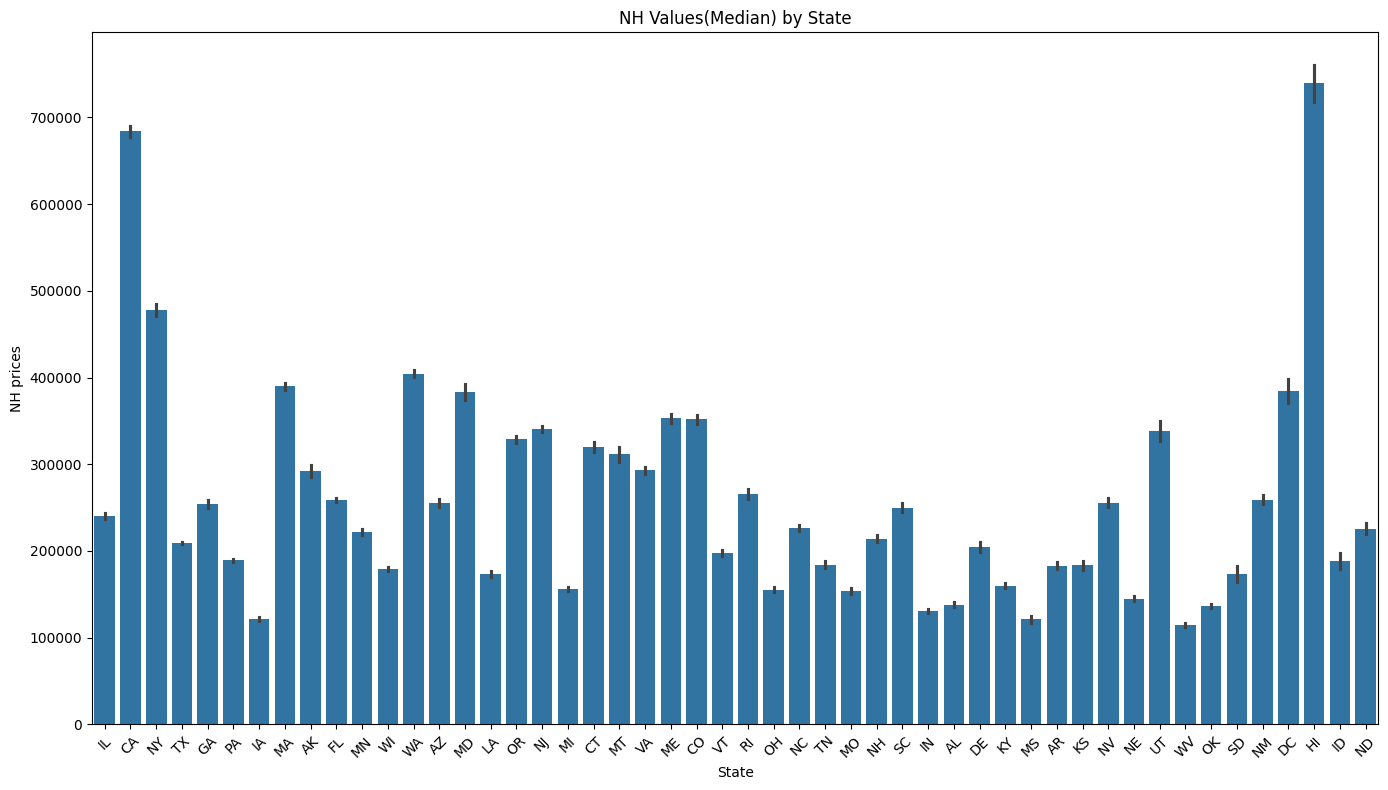

In [ ]:
unpiv_nh_values_pd = unpiv_nh_values.toPandas()

# Plot for NH Values (Median) by State
plt.figure(figsize=(14, 8))
sns.barplot(x='StateName', y='Median_NH_Values', data=unpiv_nh_values_pd)
plt.title('NH Values(Median) by State')
plt.xlabel('State')
plt.ylabel('NH prices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


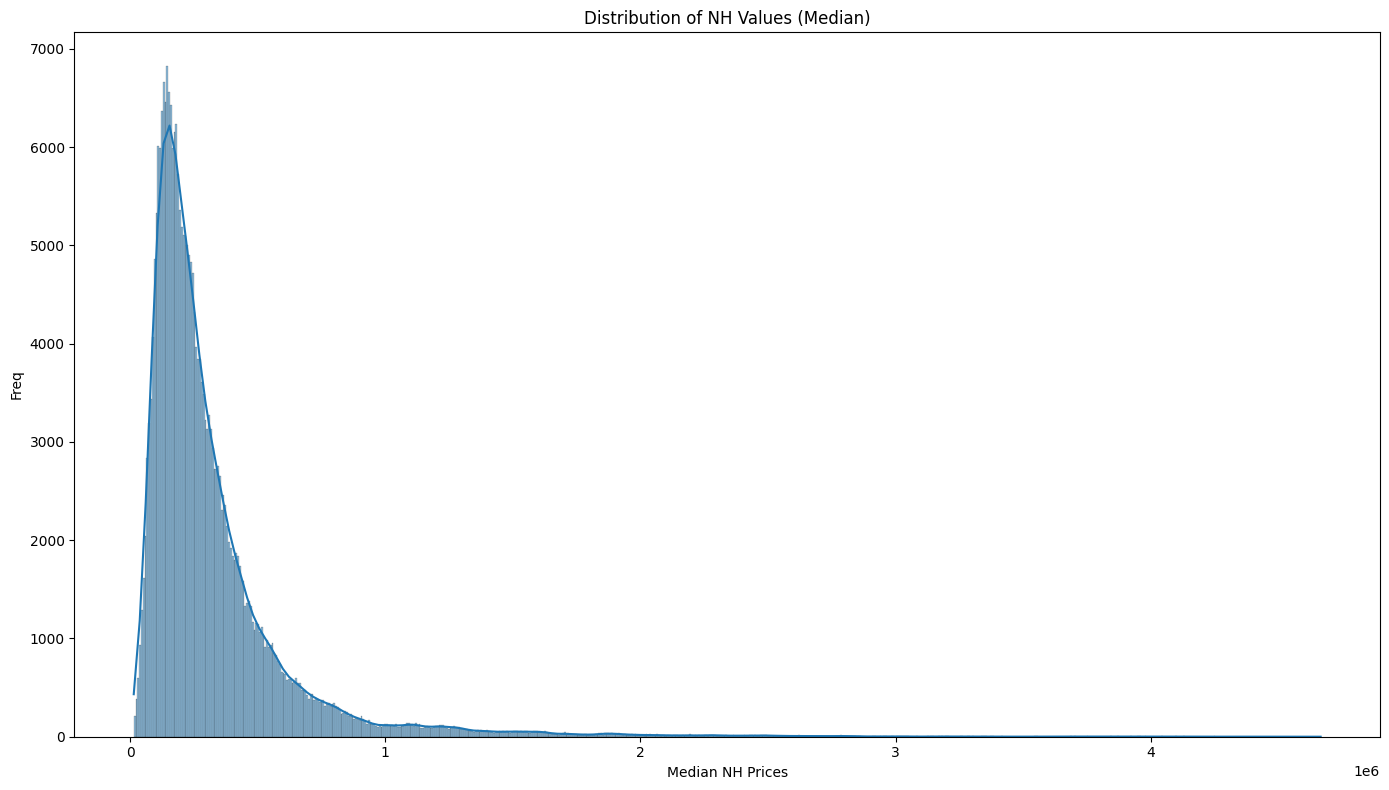

In [ ]:
# PLot distribution of NH Values (Median)
plt.figure(figsize=(14, 8))
sns.histplot(unpiv_nh_values_pd['Median_NH_Values'].dropna(), kde=True)
plt.title('Distribution of NH Values (Median)')
plt.xlabel('Median NH Prices')
plt.ylabel('Freq')
plt.tight_layout()
plt.show()

The above graphs are representation of Median NH Values.

Fig. 1 shows that there are regional disparities in median NH values for states like DC, CA and NY. The costlier regions increase the NH values.
Most states has a small error bar which show that there is lesser variation for those states.

Fig. 2 shows distribution for median NH values. It is a right skewed distribution where most values are concentrated towards to lower end. This shows that most cities have affordable housing options.

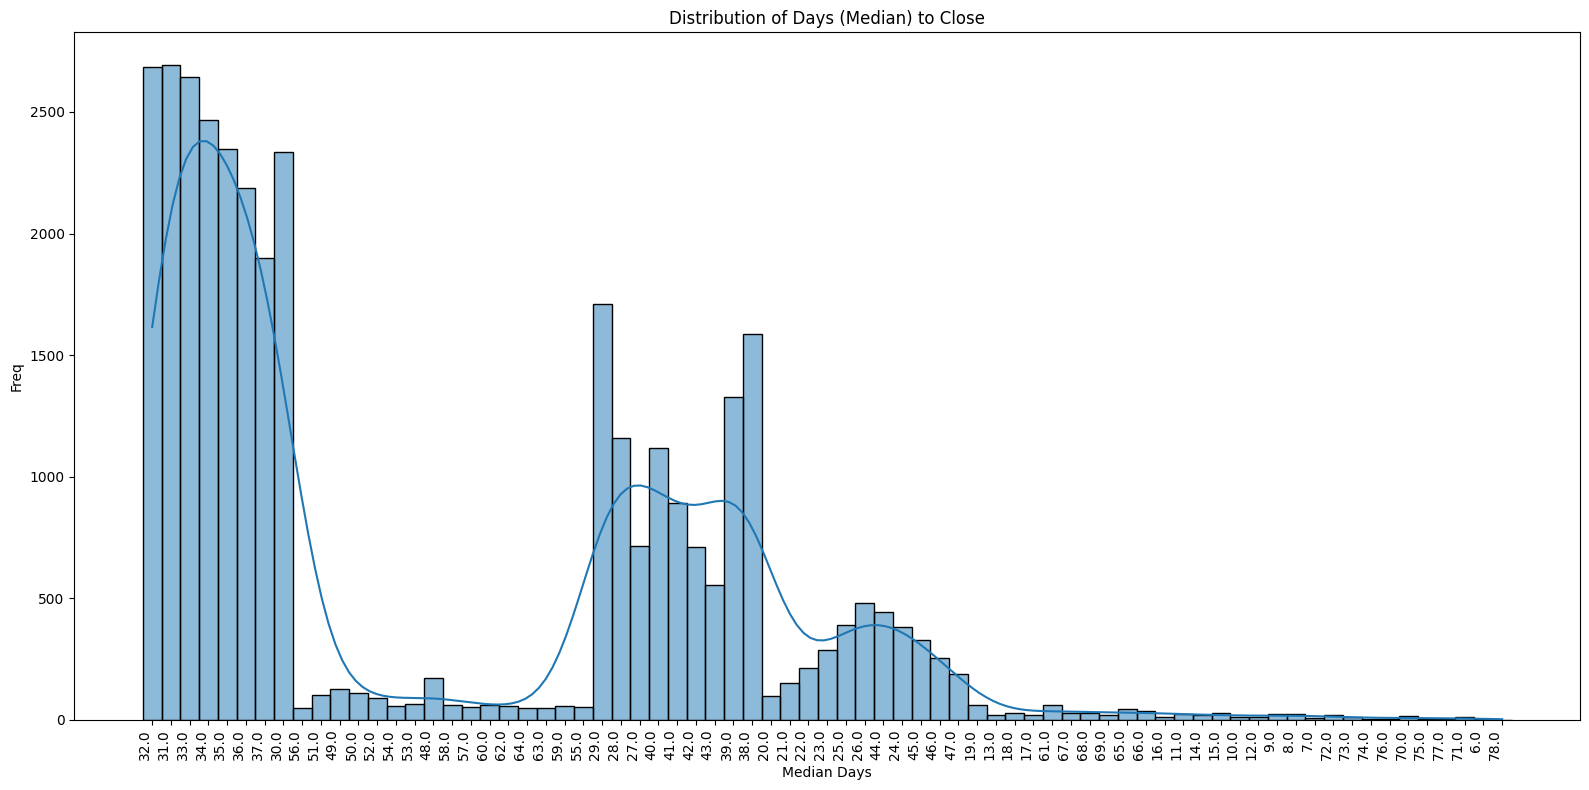

In [ ]:
unpiv_med_daystoclose_pd = unpiv_med_daystoclose.toPandas()

# Plot distribution of Days (Median) to Close
plt.figure(figsize=(16, 8))
sns.histplot(unpiv_med_daystoclose_pd['Median Days To Close'].dropna(), kde=True)
plt.title('Distribution of Days (Median) to Close')
plt.xlabel('Median Days')
plt.ylabel('Freq')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

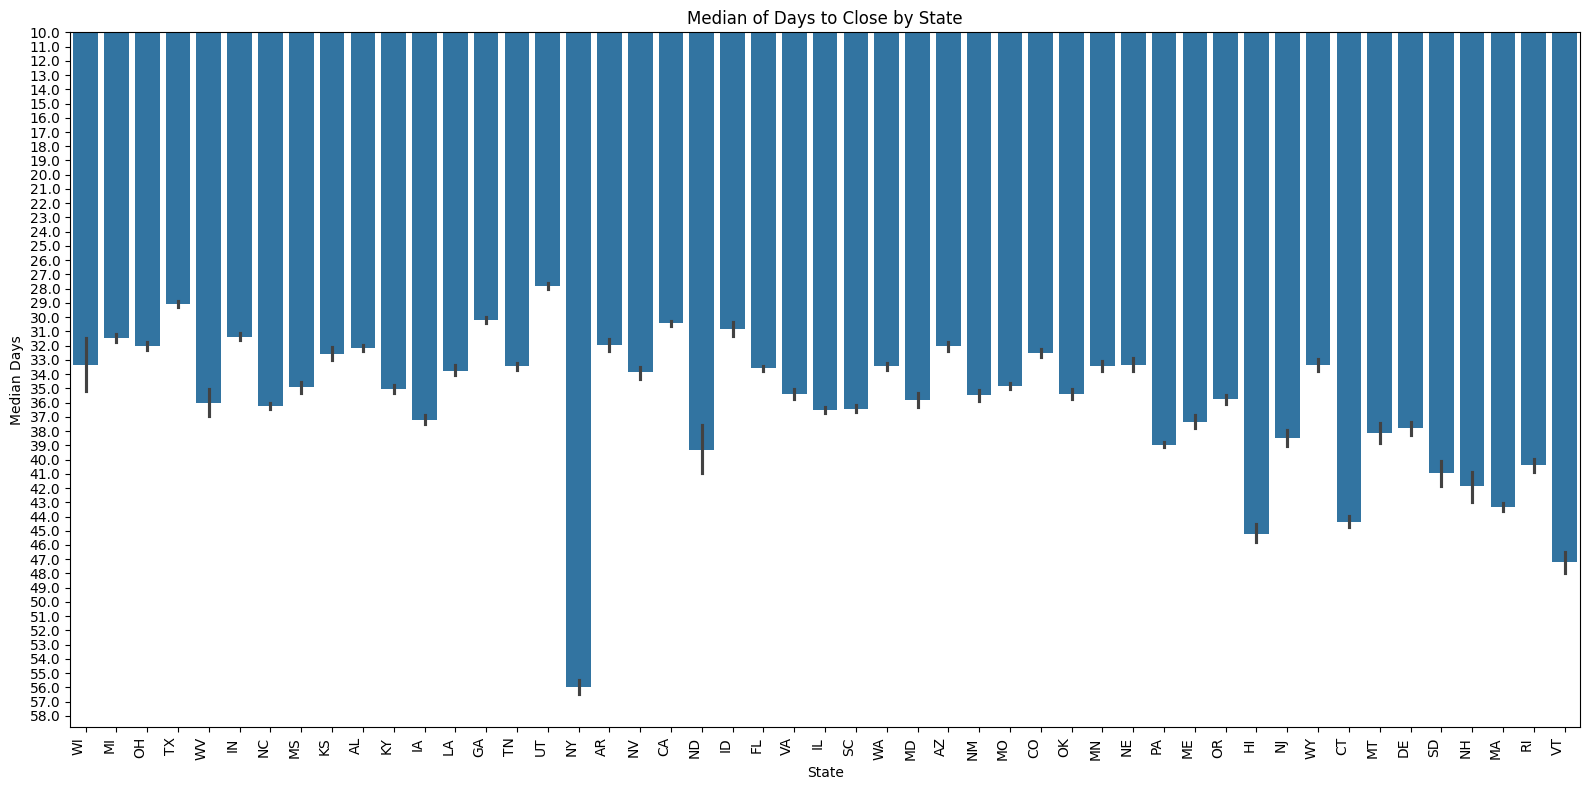

In [ ]:
sorted_data = unpiv_med_daystoclose_pd.sort_values(by='Median Days To Close', ascending=True)

# Plot for Median Days to Close and State
plt.figure(figsize=(16, 8))
sns.barplot(x='StateName', y='Median Days To Close', data=sorted_data)
plt.title('Median of Days to Close by State')
plt.xlabel('State')
plt.ylabel('Median Days')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

plt.show()

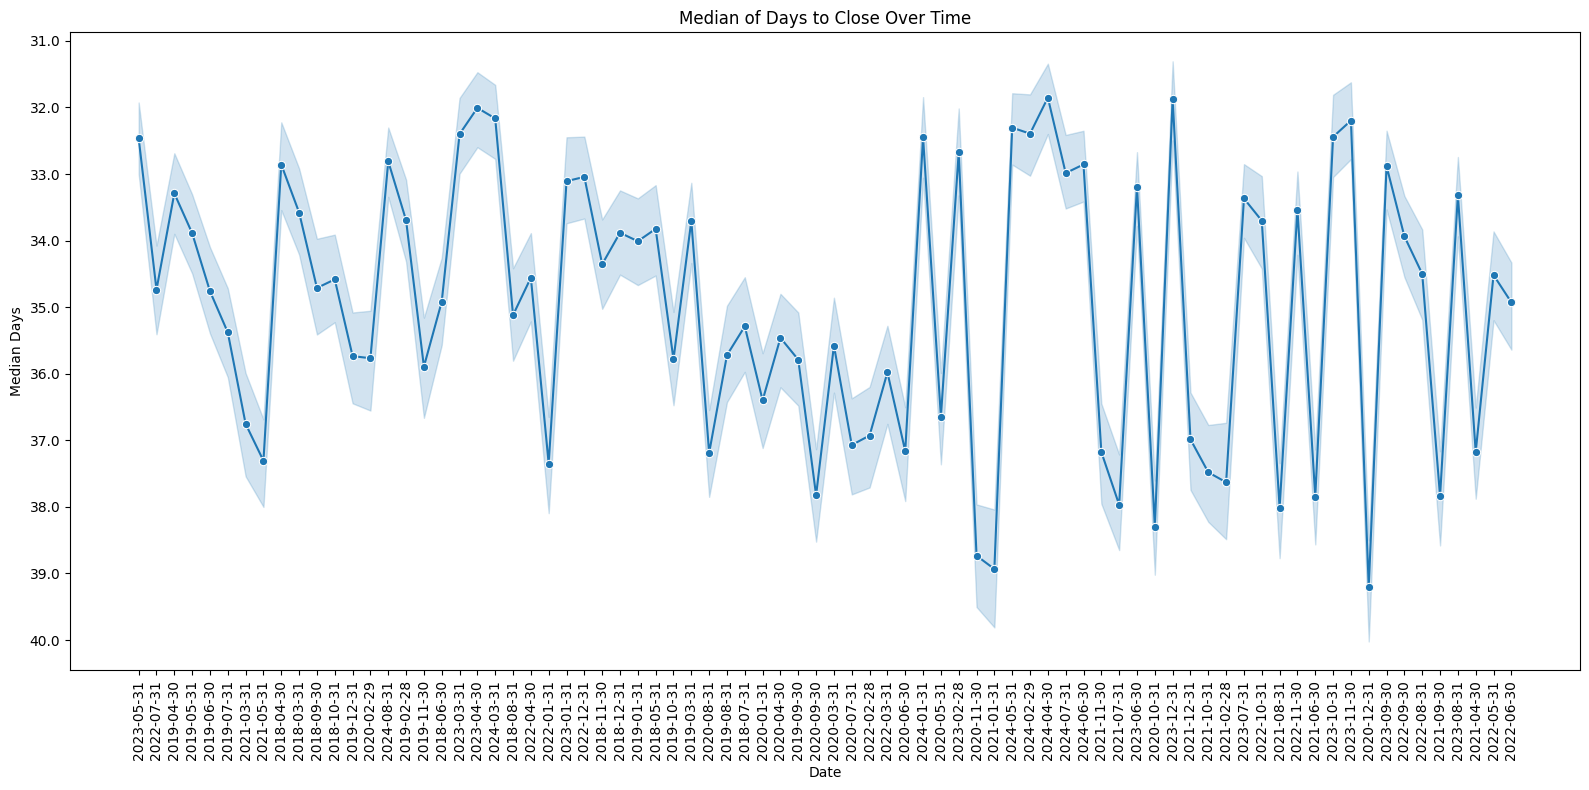

In [ ]:
# Plot for Time and Median Days to Close
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Median Days To Close', data=sorted_data, marker='o')
plt.title('Median of Days to Close Over Time')
plt.xlabel('Date')
plt.ylabel('Median Days')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The above plots are a representation for Median Days to Close

Fig. 1 shows distribution for median days to close. It is mostly a right skewed distribution. The graph shows a sharp drop as the numbers start to increase and there is high concentartion for low median days to close.

Fig. 2 shows median days to close by state. We can see high variation between states.

Fig. 3 shows median days to close over time. It illustrates the fluctuations over time. There is a rapid increase and decrease with some sharp dips.

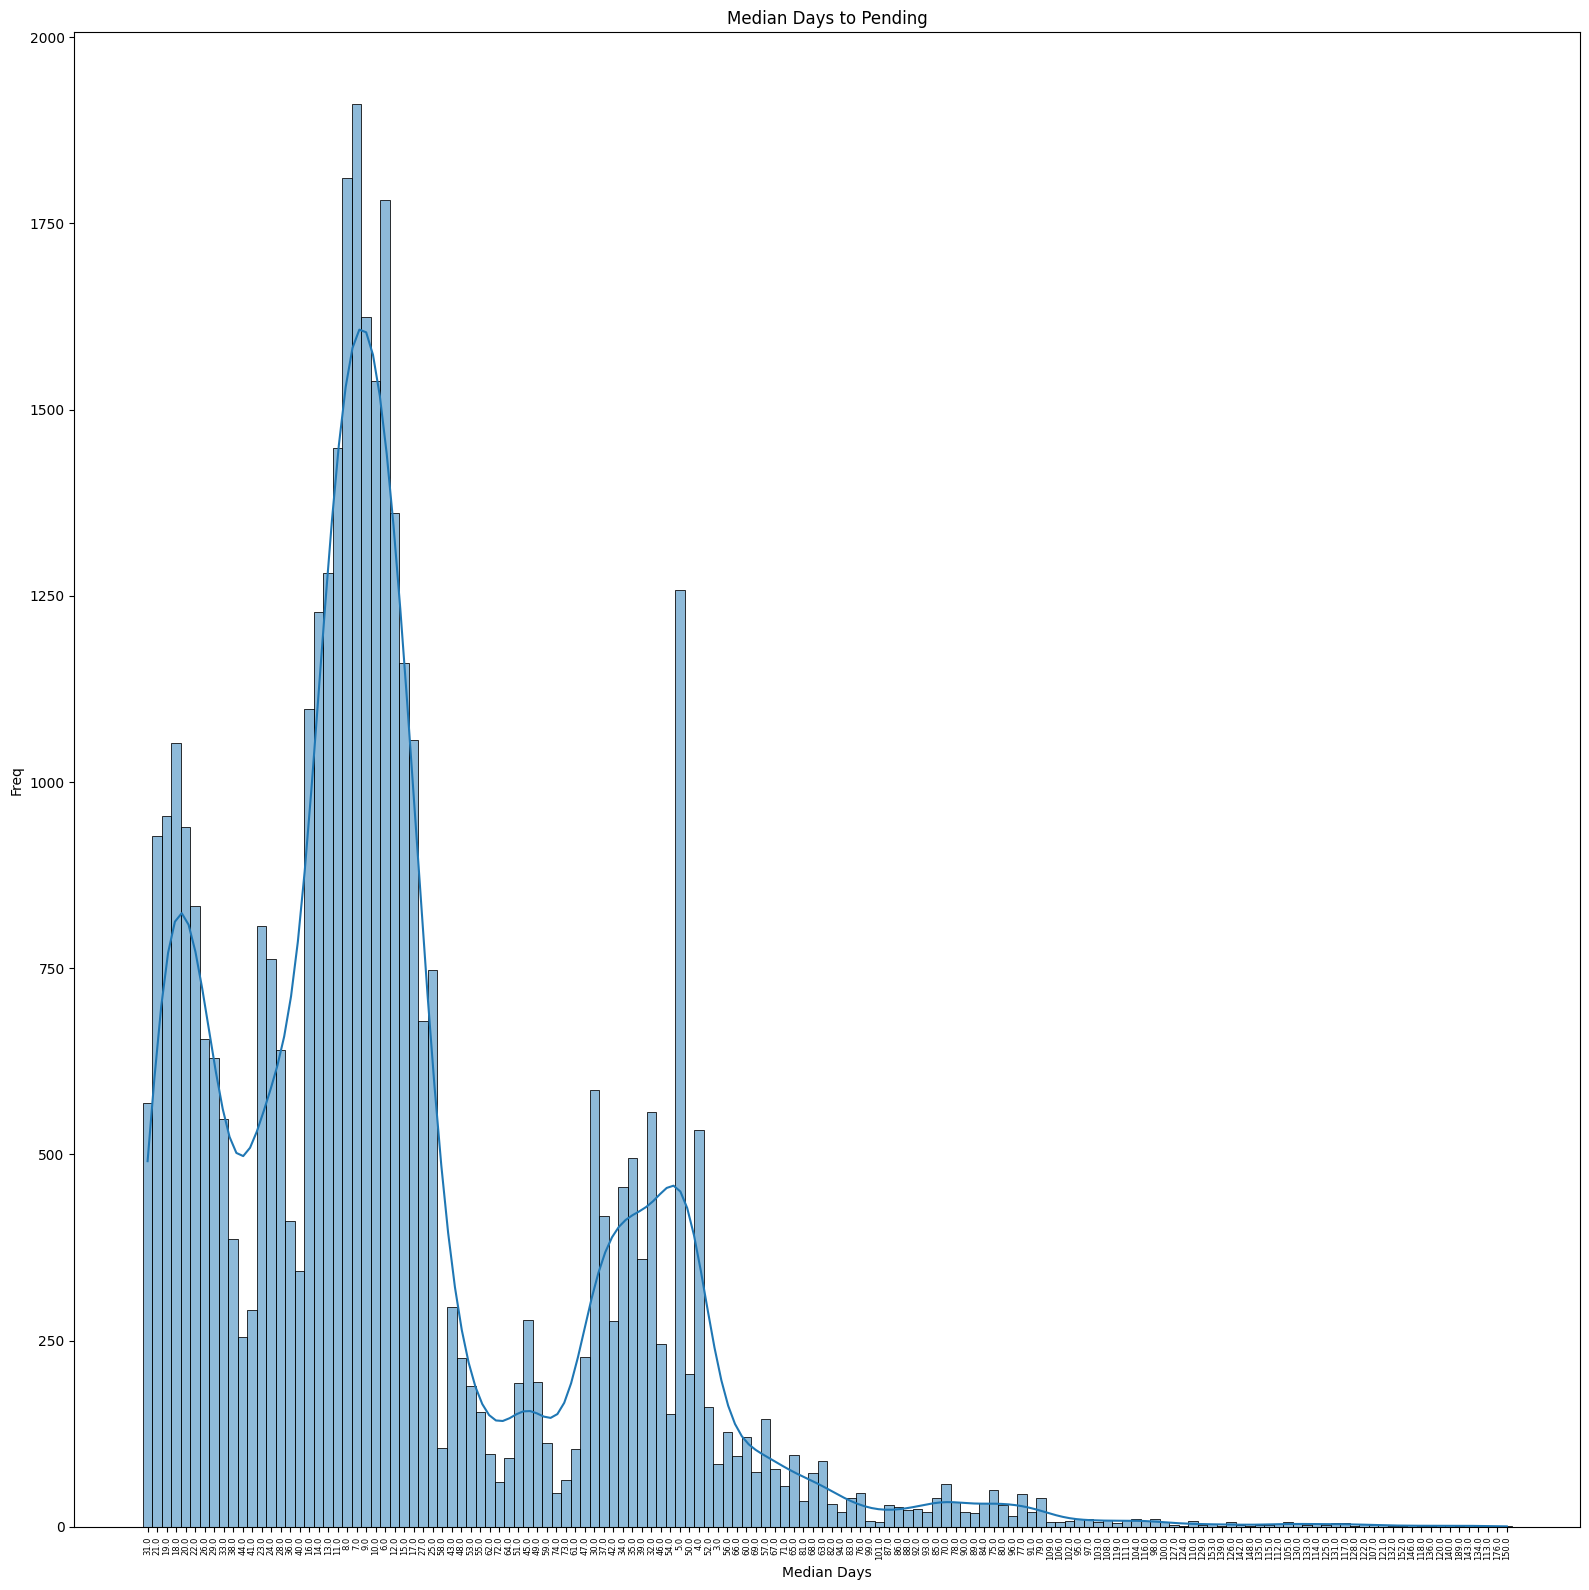

In [ ]:
unpiv_med_daystopending_pd = unpiv_med_daystopending.toPandas()

# Plot for distribution of Median Days to Pending
plt.figure(figsize=(16, 16))
sns.histplot(unpiv_med_daystopending_pd['Median Days To Pending'].dropna(), kde=True)
plt.title('Median Days to Pending')
plt.xlabel('Median Days')
plt.ylabel('Freq')
plt.xticks(rotation=90, ha='center', fontsize=6)
plt.tight_layout()
plt.show()


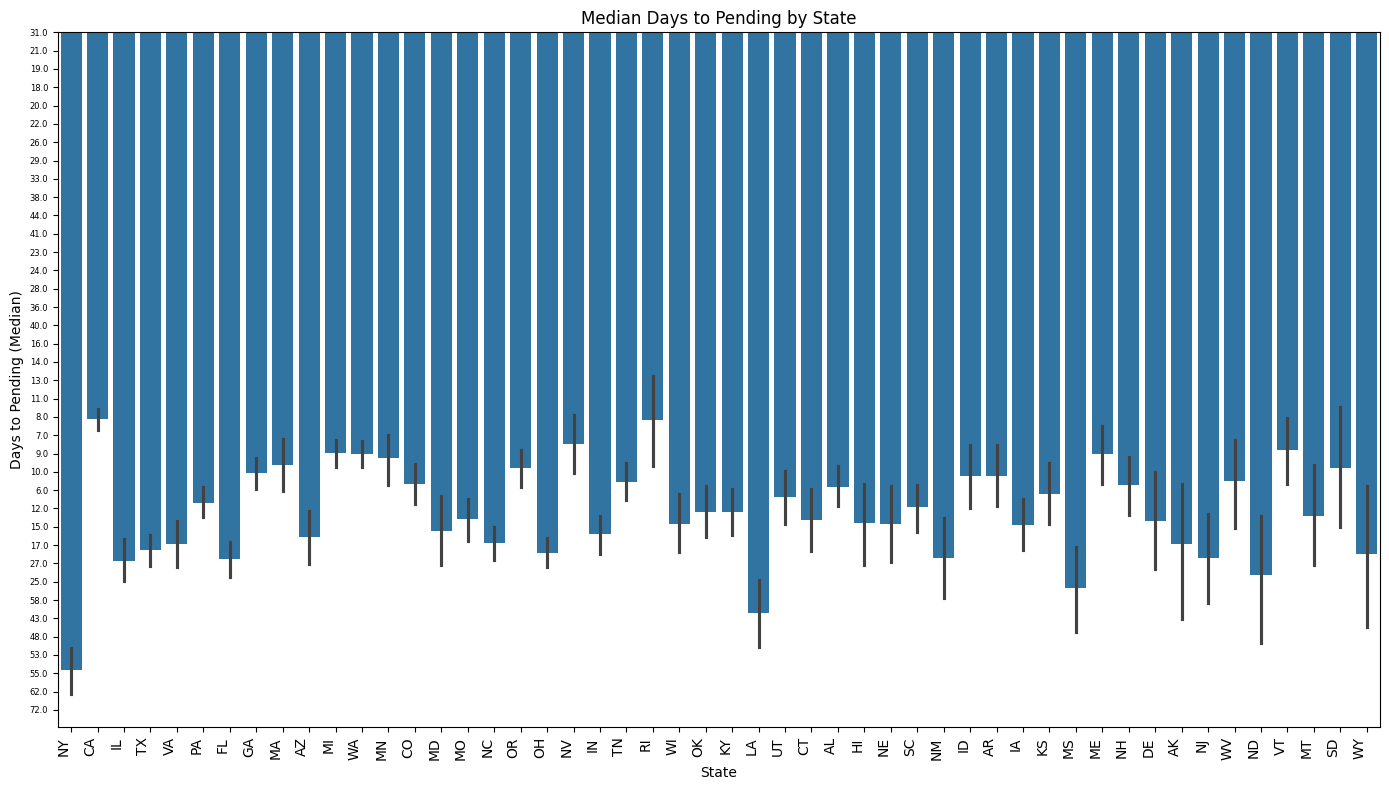

In [ ]:
# Plot for Median Days to Pending and State
plt.figure(figsize=(14, 8))
sns.barplot(x='StateName', y='Median Days To Pending', data=unpiv_med_daystopending_pd)
plt.title('Median Days to Pending by State')
plt.xlabel('State')
plt.ylabel('Days to Pending (Median)')
plt.xticks(rotation=90, ha='right')
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()


The above graphs are a representation of Median Days to pending.

Fig. 1 shows distribution for median days to pending. We can see quick drops and rises.

Fig. 2 shows median days to pending by state. It varies across states and NY, CA have the highest days to pending. It takes longer time where the population is high compared to smaller states with low population.

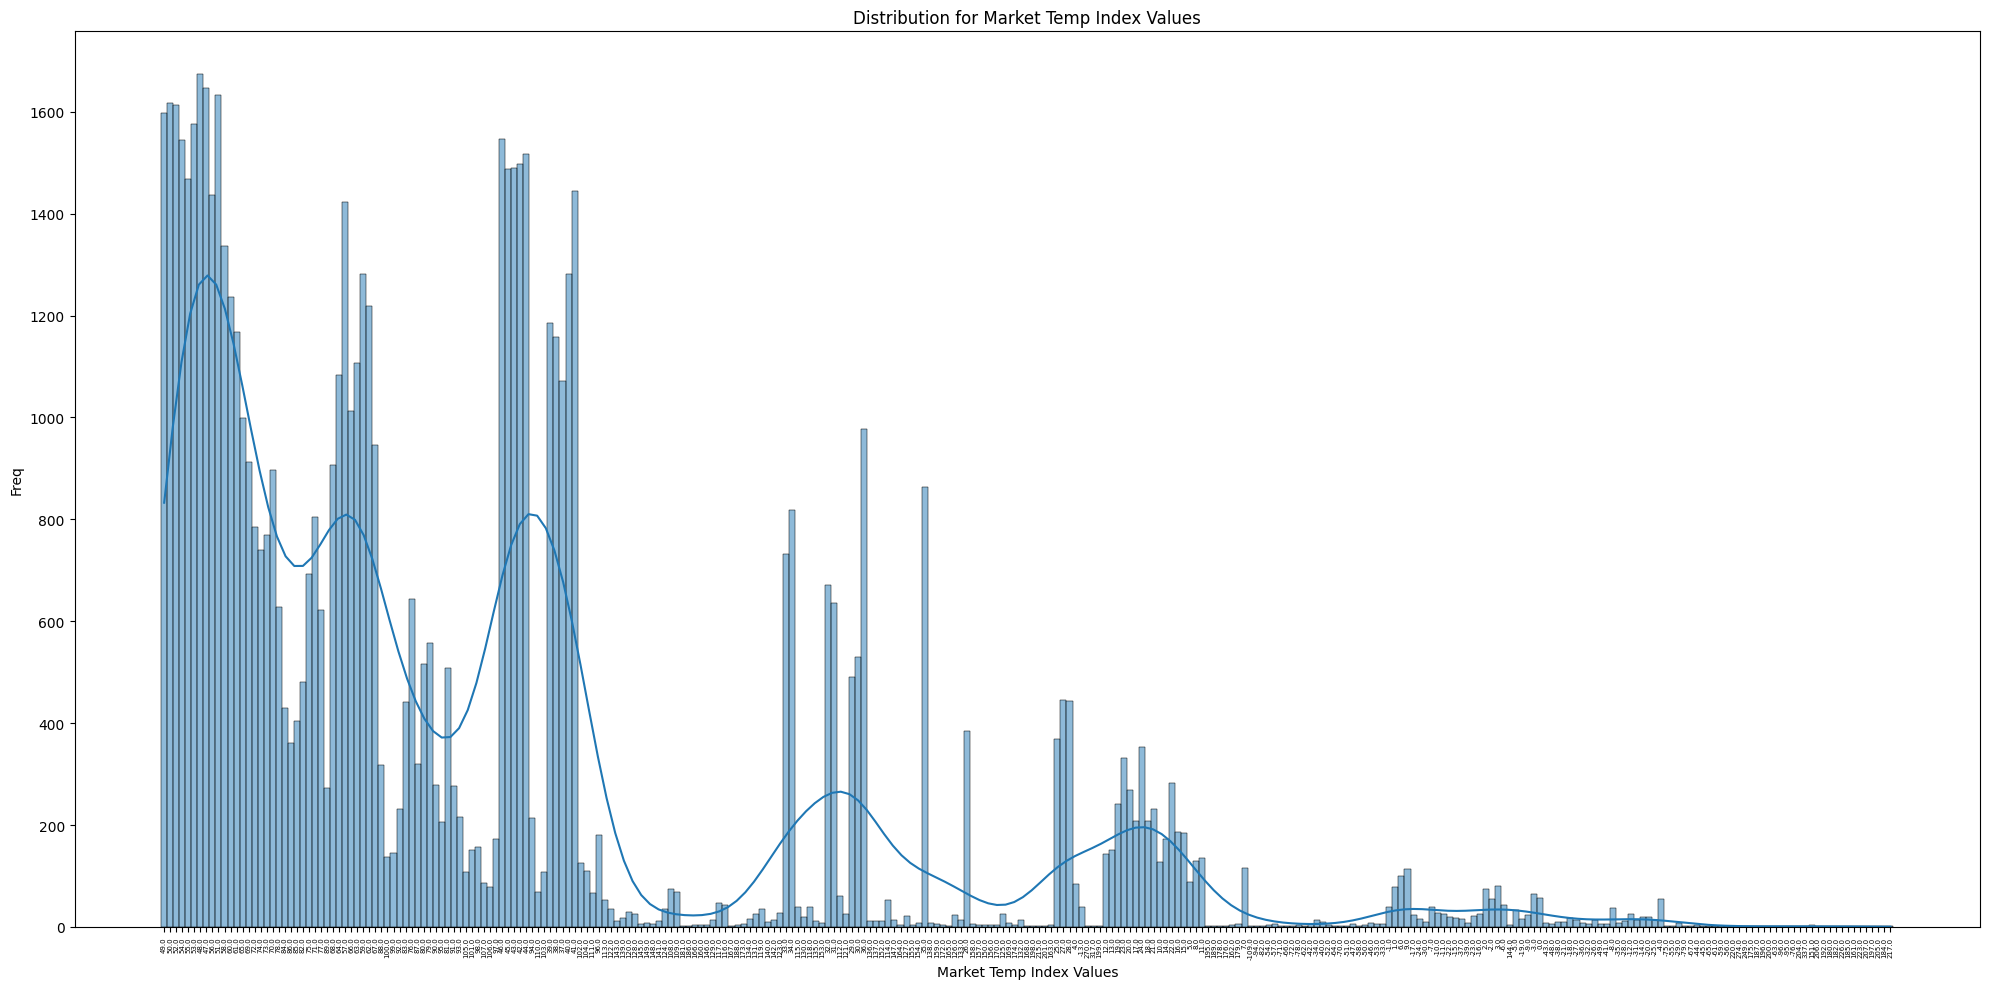

In [ ]:
unpiv_market_temp_pd = unpiv_market_temp.toPandas()

# Plot for distribution of Market Temp Index Values
plt.figure(figsize=(20, 10))
sns.histplot(unpiv_market_temp_pd['Market Temp Index Values'].dropna(), kde=True)
plt.title('Distribution for Market Temp Index Values')
plt.xlabel('Market Temp Index Values')
plt.ylabel('Freq')
plt.xticks(rotation=90, fontsize = 5)
plt.tight_layout()
plt.show()

The above chart shows distribution of Market Temp Index values. The distribution appears right skewed. Most regions are relatively stable and have slow market. The high peaks might indicate rapid market grwoth area and competitive market.

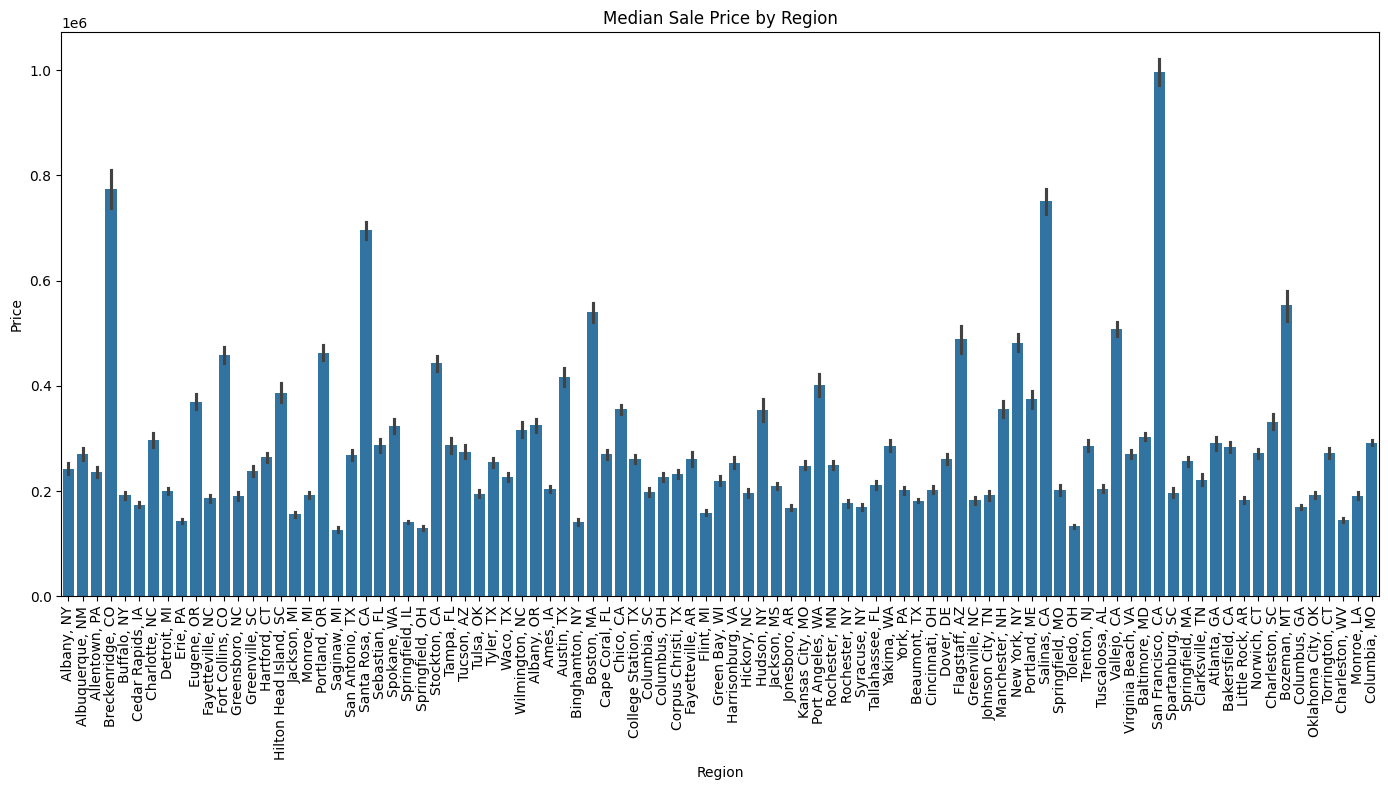

In [ ]:
final_zillow_merge_pd = final_zillow_merge.toPandas()

top_cities = final_zillow_merge_pd['City'].value_counts().head(80).index

# Plot for sale price (median) by region
plt.figure(figsize=(14, 8))
sns.barplot(x='RegionName', y='Median Sale', data=final_zillow_merge_pd[final_zillow_merge_pd['City'].isin(top_cities)])
plt.title('Median Sale Price by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


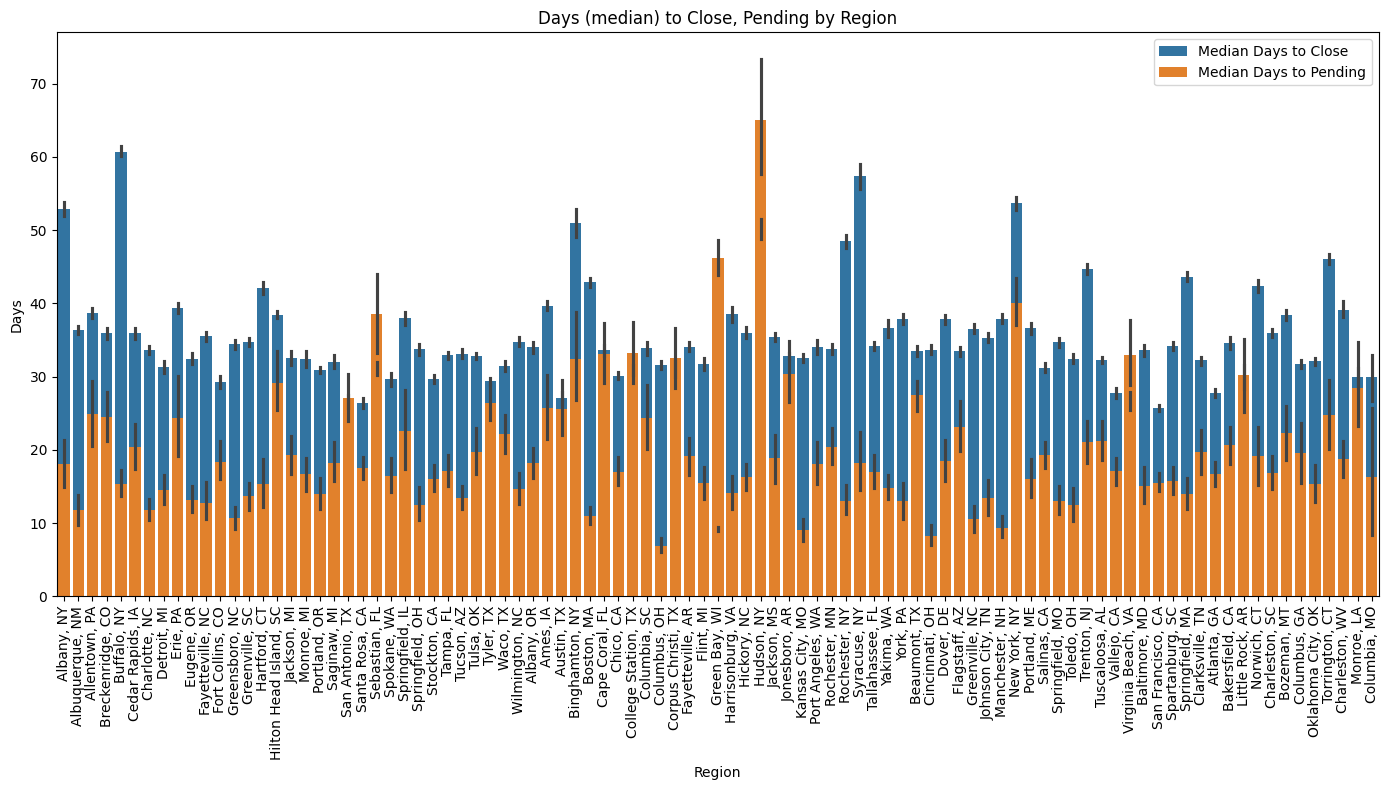

In [ ]:
# Plot for median days for closing, pending by region
plt.figure(figsize=(14, 8))
sns.barplot(x='RegionName', y='Median Days To Close', data=final_zillow_merge_pd[final_zillow_merge_pd['City'].isin(top_cities)], label='Median Days to Close')
sns.barplot(x='RegionName', y='Median Days To Pending', data=final_zillow_merge_pd[final_zillow_merge_pd['City'].isin(top_cities)], label='Median Days to Pending')
plt.title('Days (median) to Close, Pending by Region')
plt.xlabel('Region')
plt.ylabel('Days')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

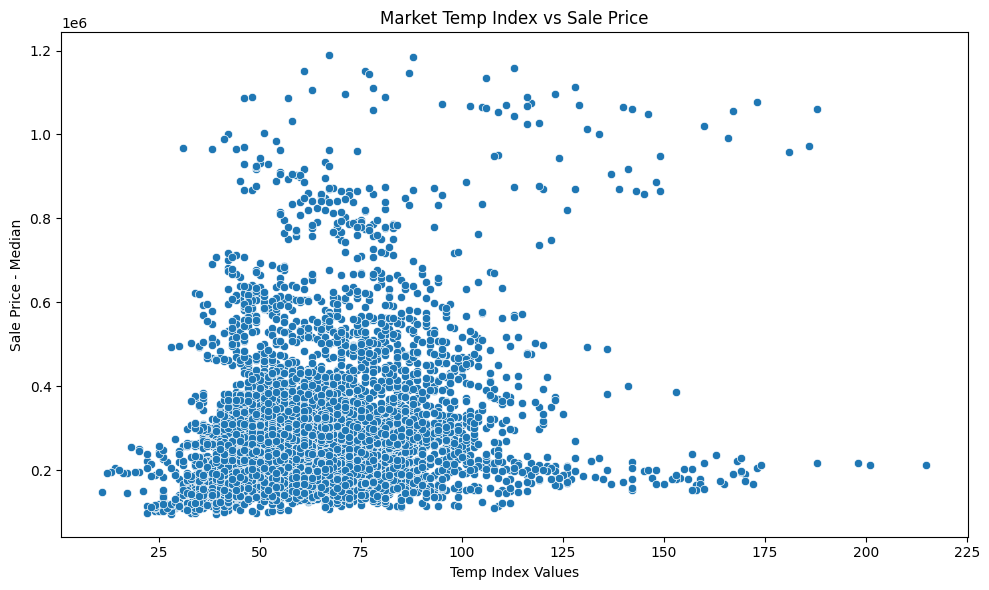

In [ ]:
# Plot for market temp index vs sale price (median)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Market Temp Index Values', y='Median Sale', data=final_zillow_merge_pd[final_zillow_merge_pd['City'].isin(top_cities)])
plt.title('Market Temp Index vs Sale Price')
plt.xlabel('Temp Index Values')
plt.ylabel('Sale Price - Median')
plt.tight_layout()
plt.show()


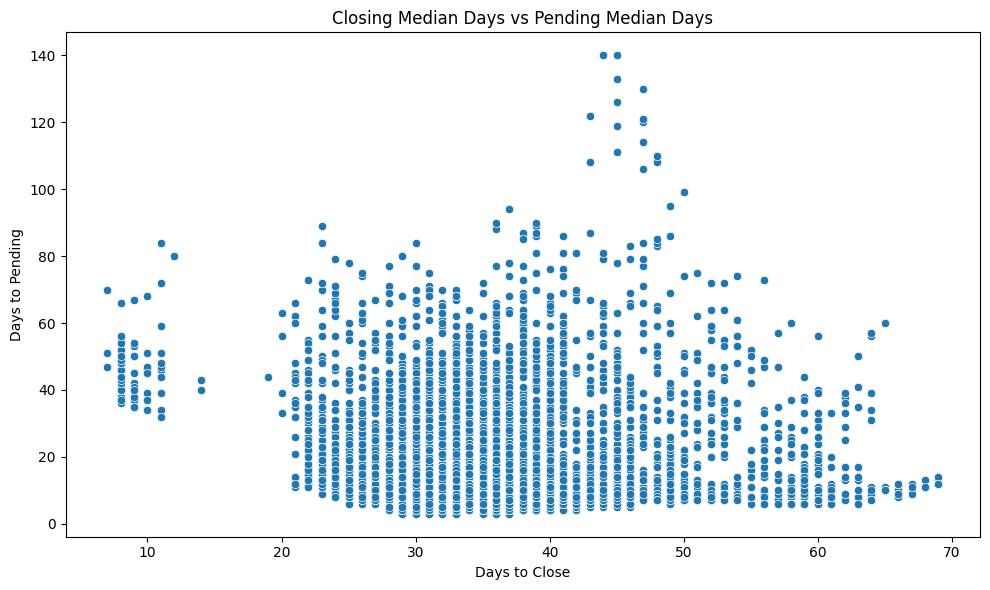

In [ ]:
# Plot for closing median days vs pending median days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Median Days To Close', y='Median Days To Pending', data=final_zillow_merge_pd[final_zillow_merge_pd['City'].isin(top_cities)])
plt.title('Closing Median Days vs Pending Median Days')
plt.xlabel('Days to Close')
plt.ylabel('Days to Pending')
plt.tight_layout()
plt.show()


Fig. 1 shows median sale price by region. NY, CA have higher selling prices compared to developing markets.

Fig. 2 shows median days to close and median days to pending by city. The graph shows how quickly a property is closed. This could be an indicator of market conditions, and demand.

Fig. 3 shows market index values by sales price indicating that higher demand areas have higher prices.

Fig. 4 shows days to close vs days to pending. Properties take longer to close than others. the plot shows slightly negative correlation. This means that if it takes more days to close, the property will be in pending stage for lesser time.

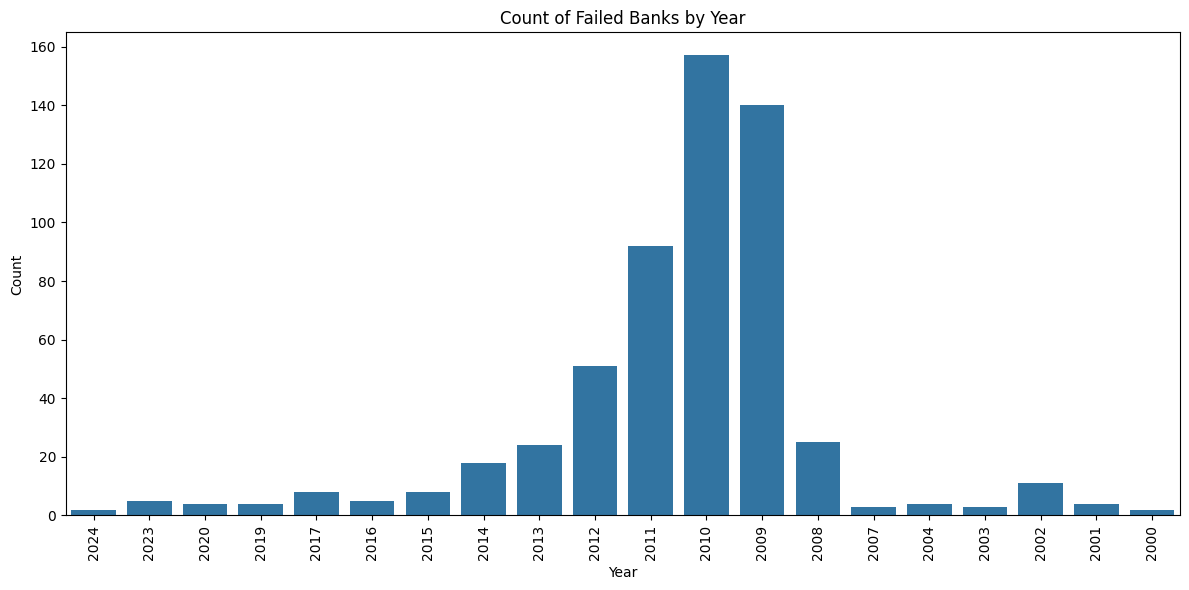

In [ ]:
failed_banks_pd = failed_banks.toPandas()

# Plot for failed banks by year
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=failed_banks_pd)
plt.title('Count of Failed Banks by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The above graph shows count of failed bank per year. It shows increase in bank failures around 2008 which was also the year of financial crisis. However, we can see recovery after that with lesser banks failed.

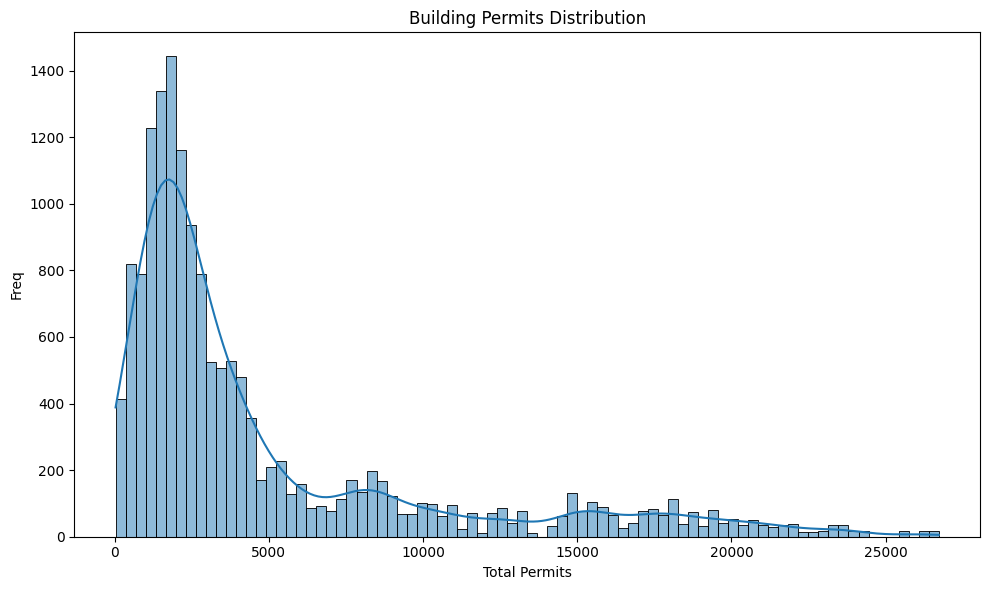

In [ ]:
merged_building_permits_w_final_zillow_merge_pd = merged_building_permits_w_final_zillow_merge.toPandas()

# Plot for building permit distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_building_permits_w_final_zillow_merge_pd['Total'], kde=True)
plt.title('Building Permits Distribution')
plt.xlabel('Total Permits')
plt.ylabel('Freq')
plt.tight_layout()
plt.show()

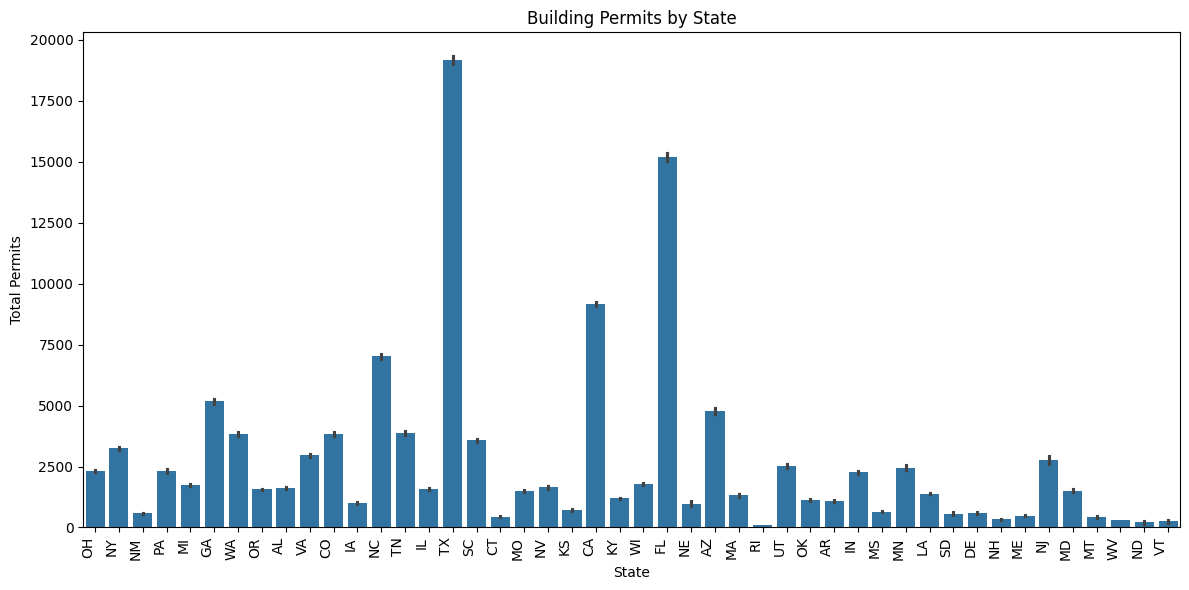

In [ ]:

# Plot for building permits by state
plt.figure(figsize=(12, 6))
sns.barplot(x='StateName', y='Total', data=merged_building_permits_w_final_zillow_merge_pd)
plt.title('Building Permits by State')
plt.xlabel('State')
plt.ylabel('Total Permits')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

The above graphs represent building permit data.

Fig. 1 shows distribution of data, it is right skewed. Most values are clustered at the lower end which signifies that many areas have low count of permits.

Fig. 2 shows building permits by state. States like Texas, Florida and California have many permits likely due to more active construction activities.

In [ ]:
def season_column(df):
    """Create market nature categories based on Market Temp Index Values"""
    return df.withColumn(
        "season",
        when((col("Month") == 'jan') | (col("Month") == 'feb') | (col("Month") == 'dec'), "winter")
        .when((col("Month") == 'apr') | (col("Month") == 'may') | (col("Month") == 'mar'), "spring")
        .when((col("Month") == 'jun') | (col("Month") == 'jul') | (col("Month") == 'aug'), "summer")
        .otherwise("fall")
    )

merged_dataset = season_column(merged_dataset)

<ipython-input-86-7c7196a87c5e>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Market Temp Index Values', y='Number of failed banks', data=merged_dataset_pd, ci = None)


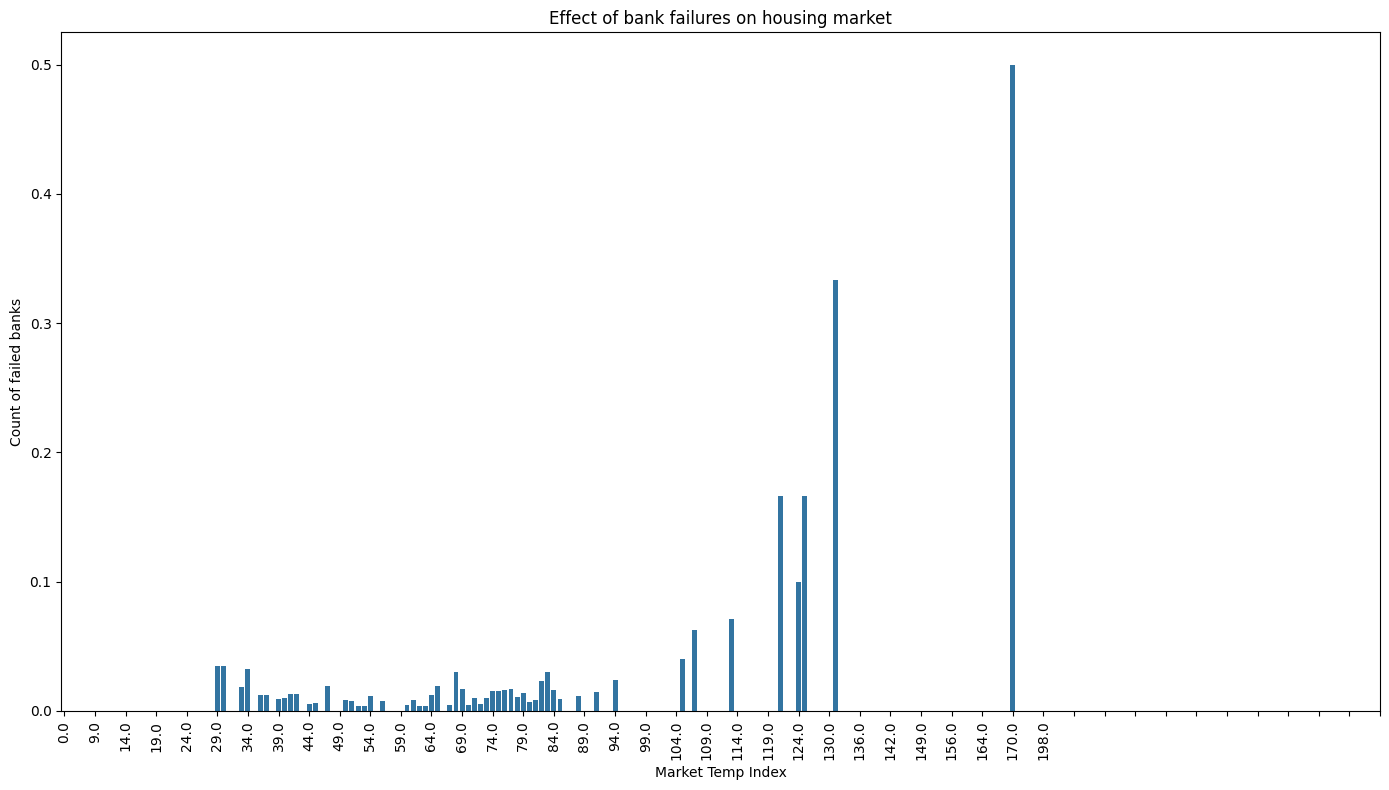

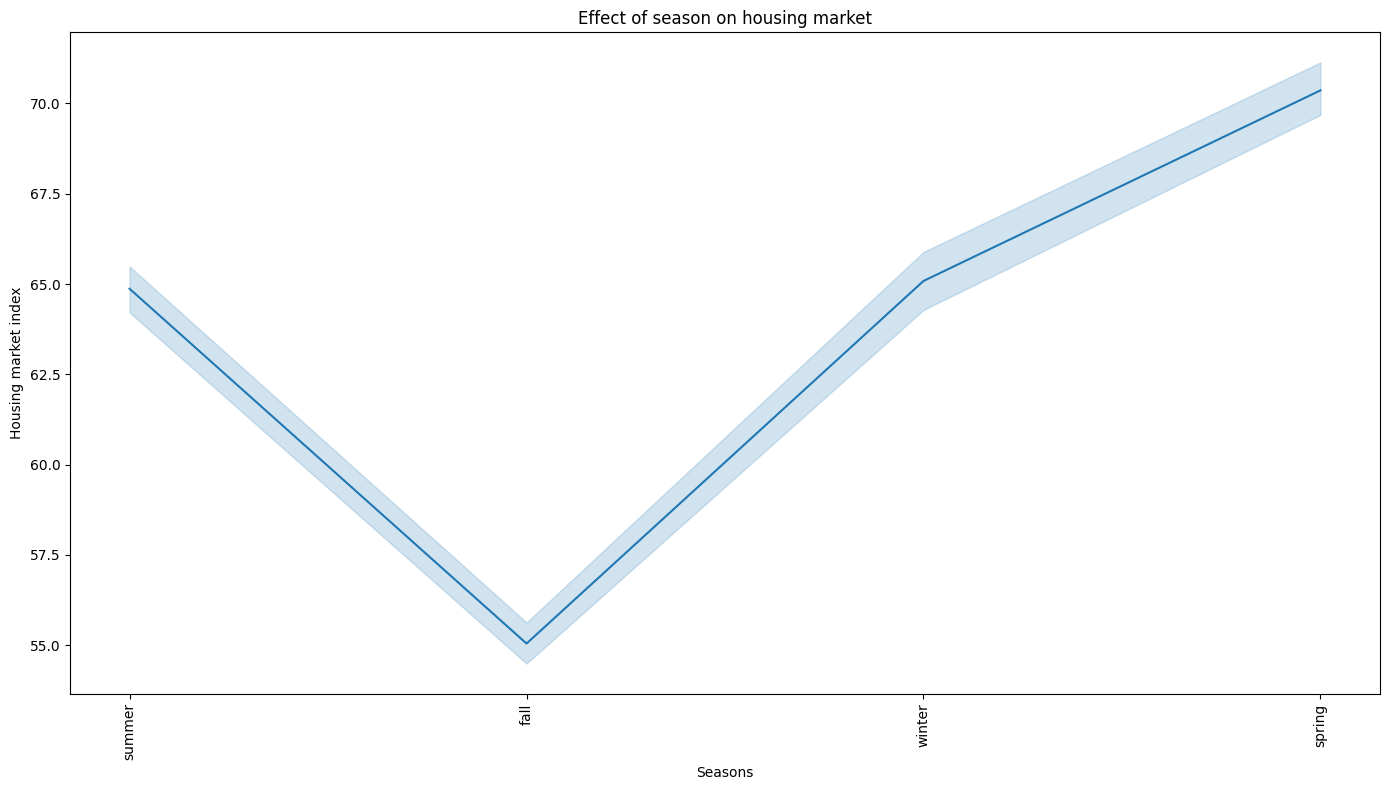

In [ ]:
import numpy as np
merged_dataset_pd = merged_dataset.toPandas()

# Plot for Effect of bank failures on housing market
plt.figure(figsize=(14, 8))
sns.barplot(x='Market Temp Index Values', y='Number of failed banks', data=merged_dataset_pd, ci = None)
plt.title('Effect of bank failures on housing market')
plt.xlabel('Market Temp Index')
plt.ylabel('Count of failed banks')
xticks = np.arange(0, 216, 5)
plt.xticks(ticks = xticks, rotation=90)
plt.tight_layout()
plt.show()

# Plot for effect of season on housing values
plt.figure(figsize=(14, 8))
sns.lineplot(x='season', y='Market Temp Index Values', data=merged_dataset_pd)
plt.title('Effect of season on housing market')
plt.ylabel('Housing market index')
plt.xlabel('Seasons')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Correlation Analysis for numerical columns.

In [ ]:
columns_of_interest = [
    'Year', 'SizeRank', 'Total', 'Median Days To Close', 'Median Days To Pending',
    'Market Temp Index Values', 'Median Sale', 'Median_NH_Values',
    'LT Real Average (10> Yrs)', 'Number of failed banks'
]

merged_dataset = merged_dataset.withColumn(
    'LT Real Average (10> Yrs)',
    fn.col('LT Real Average (10> Yrs)').cast(DoubleType())
).withColumn(
    'Number of failed banks',
    fn.col('Number of failed banks').cast(DoubleType())
)

merged_dataset_corr = merged_dataset.dropna(subset='Median_NH_Values')

# Using VectorAssembler to combine the columns into a single vector column for fn.corr()
assembler = VectorAssembler(inputCols=columns_of_interest, outputCol="features")
assembled_df = assembler.transform(merged_dataset_corr)

correlation_matrix = Correlation.corr(assembled_df, 'features')

matrix = correlation_matrix.head()[0]
correlation_array = matrix.toArray()
correlation_df = pd.DataFrame(correlation_array, columns=columns_of_interest, index=columns_of_interest)
correlation_spark_df = spark.createDataFrame(correlation_df, columns_of_interest)
columns_df = spark.createDataFrame(columns_of_interest, schema = StringType())

correlation_spark_df = correlation_spark_df.withColumn('key', fn.monotonically_increasing_id())
columns_df = columns_df.withColumn('key', fn.monotonically_increasing_id())

correlation_merged_df = columns_df.join(correlation_spark_df, on = 'key', how = 'inner').drop('key')
correlation_merged_df.show(truncate=False)

+-------------------------+-------------------+---------------------+---------------------+---------------------+----------------------+------------------------+--------------------+---------------------+-------------------------+----------------------+
|value                    |Year               |SizeRank             |Total                |Median Days To Close |Median Days To Pending|Market Temp Index Values|Median Sale         |Median_NH_Values     |LT Real Average (10> Yrs)|Number of failed banks|
+-------------------------+-------------------+---------------------+---------------------+---------------------+----------------------+------------------------+--------------------+---------------------+-------------------------+----------------------+
|Year                     |1.0                |0.08558641429789919  |0.03582925526535248  |-0.1304202315140655  |-0.3291578175585915   |0.18450126772688064     |0.20956139836898136 |0.16065114657742047  |0.5670923865402497       |0.052757

In [ ]:
correlation_merged_df.select([fn.col('value'), fn.col('Market Temp Index Values')]).show(truncate = False)

+-------------------------+------------------------+
|value                    |Market Temp Index Values|
+-------------------------+------------------------+
|Year                     |0.18450126772688064     |
|SizeRank                 |-0.19648907077138902    |
|Total                    |-0.072383867946194      |
|Median Days To Close     |0.1191427030849129      |
|Median Days To Pending   |-0.5093828085766962     |
|Market Temp Index Values |1.0                     |
|Median Sale              |0.2334069482232313      |
|Median_NH_Values         |0.18314208638319676     |
|LT Real Average (10> Yrs)|-0.32360728219279705    |
|Number of failed banks   |0.024984584199743358    |
+-------------------------+------------------------+



In [ ]:
correlation_merged_df.select([fn.col('value'), fn.col('Median_NH_Values')]).show(truncate = False)

+-------------------------+---------------------+
|value                    |Median_NH_Values     |
+-------------------------+---------------------+
|Year                     |0.16065114657742047  |
|SizeRank                 |-2.001953104742335E-4|
|Total                    |0.1739455966068288   |
|Median Days To Close     |-0.178919717979918   |
|Median Days To Pending   |-0.04166566177236381 |
|Market Temp Index Values |0.18314208638319676  |
|Median Sale              |0.9112978053172042   |
|Median_NH_Values         |1.0                  |
|LT Real Average (10> Yrs)|0.09867929784498367  |
|Number of failed banks   |0.028292717520499597 |
+-------------------------+---------------------+



# Modelling

## Binning the target variable for PySpark models. We can restart session from here once data transformation and cleaning is complete and saved as a .csv file.

In [ ]:
merged_dataset = spark.read.csv('/content/drive/My Drive/BDA_FinalProject_DataSets/merged_dataset.csv', header = True, inferSchema = True)

merged_dataset_for_modelling = merged_dataset.withColumnRenamed('Total','Total_bldg_permits_rl')
merged_dataset_for_modelling.show(5)

merged_dataset_for_modelling = merged_dataset_for_modelling.select(['State', 'City','Month', 'Year', 'SizeRank',
                                                                    'Median Days To Close', 'Median Days To Pending',
                                                                    'Market Temp Index Values','Median Sale', 'Median_NH_Values',
                                                                    'LT Real Average (10> Yrs)', 'Number of failed banks','Total_bldg_permits_rl'])

def create_market_nature_column(df):
    """Create market nature categories based on Market Temp Index Values"""
    return df.withColumn(
        "market_nature",
        when(col("Market Temp Index Values") >= 55, "sellers market")
        .when((col("Market Temp Index Values") >= 44) & (col("Market Temp Index Values") < 55), "neutral market")
        .otherwise("buyers market")
    )



merged_dataset_for_modelling = create_market_nature_column(merged_dataset_for_modelling)



merged_dataset_for_modelling = merged_dataset_for_modelling.withColumn(
    'LT Real Average (10> Yrs)',
    col('LT Real Average (10> Yrs)').cast(DoubleType())
).withColumn(
    'Number of failed banks',
    col('Number of failed banks').cast(DoubleType())
)

seller_data = merged_dataset_for_modelling.filter(merged_dataset_for_modelling.market_nature == "sellers market")
print(f"Number of values for sellers market: {seller_data.count()}")
buyer_data = merged_dataset_for_modelling.filter(merged_dataset_for_modelling.market_nature == "buyers market")
print(f"Number of values for buyers market: {buyer_data.count()}")
neutral_data = merged_dataset_for_modelling.filter(merged_dataset_for_modelling.market_nature == "neutral market")
print(f"Number of values for neutral market: {neutral_data.count()}")

buyer_adj_ratio = seller_data.count()/ buyer_data.count()
neutral_adj_ratio = seller_data.count()/ neutral_data.count()

# Depending on the count of buyers market values and neutral market value adjust sample ratio value for over-sampling
buyer_data_resampled = merged_dataset_for_modelling.filter(merged_dataset_for_modelling.market_nature == "buyers market").sample(True, buyer_adj_ratio)
print(f"Number of values for buyers market: {buyer_data_resampled.count()}")
neutral_data_resampled = merged_dataset_for_modelling.filter(merged_dataset_for_modelling.market_nature == "neutral market").sample(True, neutral_adj_ratio)
print(f"Number of values for neutral market: {neutral_data_resampled.count()}")

# Joining the classes together and shuffling the rows to prevent the possibility of unseen data during train-test-split.
merged_dataset_for_modelling_new = seller_data.union(buyer_data_resampled).union(neutral_data_resampled).orderBy(fn.rand())
merged_dataset_for_modelling.show(5)
merged_dataset_for_modelling_new.show(5)

+-----+-----+----+----------+------------+---------------------+-----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+
|State|Month|Year|      Date|      Region|Total_bldg_permits_rl|       City|RegionID|     RegionName|RegionType|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|
+-----+-----+----+----------+------------+---------------------+-----------+--------+---------------+----------+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+
|   OH|  aug|2018|2018-08-31|        ohio|                 1962|      Akron|  394304|      Akron, OH|       msa|      83|                23.0|                  34.0|                    39

In [ ]:
for col_name in merged_dataset_for_modelling_new.columns:
    null_count = merged_dataset_for_modelling_new.filter(col(col_name).isNull()).count()
    total_count = merged_dataset_for_modelling_new.count()
    print(f"Percentage of nulls in {col_name}: {(null_count/total_count)*100:.2f}%")


Percentage of nulls in State: 0.00%
Percentage of nulls in City: 0.00%
Percentage of nulls in Month: 0.00%
Percentage of nulls in Year: 0.00%
Percentage of nulls in SizeRank: 0.00%
Percentage of nulls in Median Days To Close: 0.00%
Percentage of nulls in Median Days To Pending: 0.00%
Percentage of nulls in Market Temp Index Values: 0.00%
Percentage of nulls in Median Sale: 0.00%
Percentage of nulls in Median_NH_Values: 0.46%
Percentage of nulls in LT Real Average (10> Yrs): 0.00%
Percentage of nulls in Number of failed banks: 0.00%
Percentage of nulls in Total_bldg_permits_rl: 0.00%
Percentage of nulls in market_nature: 0.00%


In [ ]:
merged_dataset_for_modelling.printSchema()

root
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- Median Days To Close: double (nullable = true)
 |-- Median Days To Pending: double (nullable = true)
 |-- Market Temp Index Values: double (nullable = true)
 |-- Median Sale: double (nullable = true)
 |-- Median_NH_Values: double (nullable = true)
 |-- LT Real Average (10> Yrs): double (nullable = true)
 |-- Number of failed banks: double (nullable = true)
 |-- Total_bldg_permits_rl: integer (nullable = true)
 |-- market_nature: string (nullable = false)



## Data Preparation and Functions

In [ ]:
import pyspark
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql.functions import col, when, isnull
from pyspark.ml.feature import StringIndexer, IndexToString, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, OneVsRest, NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [ ]:
# 1. Building a Model Evaluation function

def evaluate_model_performance(predictions, model_name):
    """Evaluate model performance and prepare visualization data with improved error handling"""
    try:
        predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
        metrics = MulticlassMetrics(predictionAndLabels)

        confusion_matrix = metrics.confusionMatrix().toArray()

        try:
            label_indexer_model = [stage for stage in predictions.schema["label"].metadata["ml_attr"]["vals"]]
        except (KeyError, AttributeError):
            label_indexer_model = [float(x[0]) for x in predictions.select("label").distinct().collect()]
            label_indexer_model.sort()

        try:
            pred_pd = predictions.select("label", "probability").toPandas()

            probabilities = np.array([x.toArray() for x in pred_pd['probability']])
            n_classes = probabilities.shape[1]

            # Create individual probability columns
            for i in range(n_classes):
                pred_pd[f'probability_{i}'] = probabilities[:, i]

            y_test = label_binarize(pred_pd['label'].values, classes=range(n_classes))

            # Compute ROC curves
            roc_data = {'fpr': {}, 'tpr': {}, 'roc_auc': {}}

            for i in range(n_classes):
                try:
                    fpr, tpr, _ = roc_curve(y_test[:, i], probabilities[:, i])
                    roc_auc = auc(fpr, tpr)
                    roc_data['fpr'][i] = fpr
                    roc_data['tpr'][i] = tpr
                    roc_data['roc_auc'][i] = roc_auc
                except Exception as e:
                    print(f"Warning: Could not calculate ROC curve for class {i}: {str(e)}")
                    roc_data['fpr'][i] = []
                    roc_data['tpr'][i] = []
                    roc_data['roc_auc'][i] = None

        except Exception as e:
            print(f"Warning: Error calculating ROC curves for {model_name}: {str(e)}")
            roc_data = {'fpr': {}, 'tpr': {}, 'roc_auc': {}}

        # Calculate metrics with error handling
        class_metrics = []
        for i, label in enumerate(label_indexer_model):
            try:
                metrics_dict = {
                    'Class': label,
                    'Precision': metrics.precision(float(i)),
                    'Recall': metrics.recall(float(i)),
                    'F1-Score': metrics.fMeasure(float(i))
                }
                if i in roc_data['roc_auc'] and roc_data['roc_auc'][i] is not None:
                    metrics_dict['ROC AUC'] = roc_data['roc_auc'][i]
                class_metrics.append(metrics_dict)
            except Exception as e:
                print(f"Warning: Could not calculate metrics for class {label}: {str(e)}")
                metrics_dict = {
                    'Class': label,
                    'Precision': None,
                    'Recall': None,
                    'F1-Score': None
                }
                class_metrics.append(metrics_dict)

        metrics_df = pd.DataFrame(class_metrics)

        return {
            'confusion_matrix': confusion_matrix,
            'class_labels': label_indexer_model,
            'roc_curves': roc_data,
            'metrics': metrics_df
        }

    except Exception as e:
        print(f"Error in evaluation for {model_name}: {str(e)}")
        return {
            'confusion_matrix': None,
            'class_labels': None,
            'roc_curves': {'fpr': {}, 'tpr': {}, 'roc_auc': {}},
            'metrics': pd.DataFrame()
        }

In [ ]:
# 2. Creating a visualization function for Confusion Matrix and AUC-ROC Curve

def plot_evaluation_results(results, model_name):
    """
    Create visualizations for model evaluation results including:
    1. Confusion Matrix Heatmap
    2. ROC Curves for each class
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    confusion_matrix = results['confusion_matrix']
    class_labels = results['class_labels']

    sns.heatmap(confusion_matrix,
                annot=True,
                fmt='g',
                cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=ax1)

    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=45)

    # ROC Curves
    roc_curves = results['roc_curves']

    for i in range(len(class_labels)):
        if i in roc_curves['fpr'] and len(roc_curves['fpr'][i]) > 0:
            ax2.plot(roc_curves['fpr'][i],
                    roc_curves['tpr'][i],
                    label=f'{class_labels[i]} (AUC = {roc_curves["roc_auc"][i]:.2f})')

    ax2.plot([0, 1], [0, 1], 'k--', label='Random') # THis is a diagonal line for the random classifier

    ax2.set_title(f'ROC Curves - {model_name}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    metrics_df = results['metrics']

    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    if 'ROC AUC' in metrics_df.columns:
        metrics_to_plot.append('ROC AUC')

    melted_df = metrics_df.melt(id_vars=['Class'],
                               value_vars=metrics_to_plot,
                               var_name='Metric',
                               value_name='Score')

    sns.barplot(x='Class', y='Score', hue='Metric', data=melted_df)
    plt.title(f'Performance Metrics by Class - {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# 3. Data Preparation

all_results = {'base_models': {}}

categorical_cols = ['State', 'City', 'Month', 'Year']
numerical_cols = ['Median Days To Close', 'Median Days To Pending', 'Median Sale',
                 'Median_NH_Values', 'LT Real Average (10> Yrs)', 'Number of failed banks','Total_bldg_permits_rl']

for col_name in numerical_cols:
    merged_dataset_for_modelling_new = merged_dataset_for_modelling_new.withColumn(
        col_name,
        when(col(col_name).isNull(), 0.0).otherwise(col(col_name).cast(DoubleType()))
    )

merged_dataset_for_modelling_new = merged_dataset_for_modelling_new.withColumn(
    'Year',
    col('Year').cast(StringType())
)

# Verify the schema after conversion
merged_dataset_for_modelling_new.printSchema()

root
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- Median Days To Close: double (nullable = true)
 |-- Median Days To Pending: double (nullable = true)
 |-- Market Temp Index Values: double (nullable = true)
 |-- Median Sale: double (nullable = true)
 |-- Median_NH_Values: double (nullable = true)
 |-- LT Real Average (10> Yrs): double (nullable = true)
 |-- Number of failed banks: double (nullable = true)
 |-- Total_bldg_permits_rl: double (nullable = true)
 |-- market_nature: string (nullable = false)



In [ ]:
# 4. Feature Processing and Pipeline Setup

# Feature Processing Pipeline Components and applying numeric columns and categorical columns to the pipeline.
label_indexer = StringIndexer(inputCol="market_nature", outputCol="label")
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_Vec") for col in categorical_cols]
numeric_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features",
    handleInvalid="skip"
)
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)
final_assembler = VectorAssembler(
    inputCols=["scaled_numerical_features"] + [f"{col}_Vec" for col in categorical_cols],
    outputCol="features"
)

train_data, val_data, test_data = merged_dataset_for_modelling_new.randomSplit([0.7, 0.10, 0.20], seed=42)

# Removing any remaining null values as a final data cleaning measure.
train_data = train_data.na.drop()
val_data = val_data.na.drop()
test_data = test_data.na.drop()

In [ ]:
# ENsuring that train_data is split from balanced dataset
train_data.groupBy(fn.col('market_nature')).count().show()

+--------------+-----+
| market_nature|count|
+--------------+-----+
| buyers market| 5329|
|neutral market| 5306|
|sellers market| 5209|
+--------------+-----+



In [ ]:
train_data.show()

+-----+----------+-----+----+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+---------------------+--------------+
|State|      City|Month|Year|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|Total_bldg_permits_rl| market_nature|
+-----+----------+-----+----+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+---------------------+--------------+
|   AL|Birmingham|  apr|2019|      51|                31.0|                  14.0|                    53.0|   179380.0| 38302.47791083876|                      0.9|                   0.0|               1500.0|neutral market|
|   AL|Birmingham|  apr|2020|      51|                33.0|                  12.0|                  

In [ ]:
for col_name in train_data.columns:
    null_count = train_data.filter(col(col_name).isNull()).count()
    total_count = train_data.count()
    print(f"Percentage of nulls in {col_name}: {(null_count/total_count)*100:.2f}%")

Percentage of nulls in State: 0.00%
Percentage of nulls in City: 0.00%
Percentage of nulls in Month: 0.00%
Percentage of nulls in Year: 0.00%
Percentage of nulls in SizeRank: 0.00%
Percentage of nulls in Median Days To Close: 0.00%
Percentage of nulls in Median Days To Pending: 0.00%
Percentage of nulls in Market Temp Index Values: 0.00%
Percentage of nulls in Median Sale: 0.00%
Percentage of nulls in Median_NH_Values: 0.00%
Percentage of nulls in LT Real Average (10> Yrs): 0.00%
Percentage of nulls in Number of failed banks: 0.00%
Percentage of nulls in Total_bldg_permits_rl: 0.00%
Percentage of nulls in market_nature: 0.00%


In [ ]:
for col_name in val_data.columns:
    null_count = val_data.filter(col(col_name).isNull()).count()
    total_count = val_data.count()
    print(f"Percentage of nulls in {col_name}: {(null_count/total_count)*100:.2f}%")

Percentage of nulls in State: 0.00%
Percentage of nulls in City: 0.00%
Percentage of nulls in Month: 0.00%
Percentage of nulls in Year: 0.00%
Percentage of nulls in SizeRank: 0.00%
Percentage of nulls in Median Days To Close: 0.00%
Percentage of nulls in Median Days To Pending: 0.00%
Percentage of nulls in Market Temp Index Values: 0.00%
Percentage of nulls in Median Sale: 0.00%
Percentage of nulls in Median_NH_Values: 0.00%
Percentage of nulls in LT Real Average (10> Yrs): 0.00%
Percentage of nulls in Number of failed banks: 0.00%
Percentage of nulls in Total_bldg_permits_rl: 0.00%
Percentage of nulls in market_nature: 0.00%


In [ ]:
for col_name in test_data.columns:
    null_count = test_data.filter(col(col_name).isNull()).count()
    total_count = test_data.count()
    print(f"Percentage of nulls in {col_name}: {(null_count/total_count)*100:.2f}%")

Percentage of nulls in State: 0.00%
Percentage of nulls in City: 0.00%
Percentage of nulls in Month: 0.00%
Percentage of nulls in Year: 0.00%
Percentage of nulls in SizeRank: 0.00%
Percentage of nulls in Median Days To Close: 0.00%
Percentage of nulls in Median Days To Pending: 0.00%
Percentage of nulls in Market Temp Index Values: 0.00%
Percentage of nulls in Median Sale: 0.00%
Percentage of nulls in Median_NH_Values: 0.00%
Percentage of nulls in LT Real Average (10> Yrs): 0.00%
Percentage of nulls in Number of failed banks: 0.00%
Percentage of nulls in Total_bldg_permits_rl: 0.00%
Percentage of nulls in market_nature: 0.00%


In [ ]:
train_data.show(5)

+-----+----------+-----+----+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+---------------------+--------------+
|State|      City|Month|Year|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|Total_bldg_permits_rl| market_nature|
+-----+----------+-----+----+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+---------------------+--------------+
|   AL|Birmingham|  apr|2019|      51|                31.0|                  14.0|                    53.0|   179380.0| 38302.47791083876|                      0.9|                   0.0|               1500.0|neutral market|
|   AL|Birmingham|  apr|2020|      51|                33.0|                  12.0|                  

## Random Forest Modeling

In [ ]:
# 1. Random Forest Model Definition

base_model = {'Random Forest':RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=10,
    seed=42,
    predictionCol="prediction",
    probabilityCol="probability"
)}
rf_model = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=10,
    seed=42,
    predictionCol="prediction",
    probabilityCol="probability"
)

In [ ]:
# 2. Preparing Feature Names and Feature Importance Visualization function for Inference using Random Forest.

def get_feature_names(pipeline_model, categorical_cols, numerical_cols):
    """
    Get list of feature names after one-hot encoding using the fitted pipeline
    """
    feature_names = []

    feature_names.extend(numerical_cols)
    print(f"Number of numerical features: {len(numerical_cols)}")

    total_categorical_features = 0
    for i, col in enumerate(categorical_cols):
        try:
            indexer = pipeline_model.stages[i + 1]
            encoder = pipeline_model.stages[i + len(categorical_cols) + 1]

            n_categories = encoder.categorySizes[0]
            total_categorical_features += n_categories - 1

            feature_names.extend([f"{col}_{j}" for j in range(n_categories - 1)])

            print(f"Column {col}: {n_categories - 1} encoded features")

        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")

    print(f"Total categorical features after encoding: {total_categorical_features}")
    print(f"Total features: {len(feature_names)}")
    return feature_names

def plot_feature_importance(pipeline_model, categorical_cols, numerical_cols, top_n=20):
    """
    Visualize feature importances from Random Forest model
    """
    rf_model = pipeline_model.stages[-1]

    importances = rf_model.featureImportances.toArray()
    print(f"\nNumber of importance scores: {len(importances)}")

    print("\nGetting feature names...")
    feature_names = get_feature_names(pipeline_model, categorical_cols, numerical_cols)

    if len(feature_names) != len(importances):
        print("\nDetailed feature composition:")
        print(f"Numerical features: {numerical_cols}")
        print(f"Categorical features: {categorical_cols}")
        print(f"Feature names length: {len(feature_names)}")
        print(f"Importance scores length: {len(importances)}")
        return None

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return feature_importance_df


===== Training Models =====

Training RandomForestClassifier_842f3e0672ae...

Predictions DataFrame Schema:
root
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- Median Days To Close: double (nullable = true)
 |-- Median Days To Pending: double (nullable = true)
 |-- Market Temp Index Values: double (nullable = true)
 |-- Median Sale: double (nullable = true)
 |-- Median_NH_Values: double (nullable = true)
 |-- LT Real Average (10> Yrs): double (nullable = true)
 |-- Number of failed banks: double (nullable = true)
 |-- Total_bldg_permits_rl: double (nullable = true)
 |-- market_nature: string (nullable = false)
 |-- label: double (nullable = false)
 |-- State_Index: double (nullable = false)
 |-- City_Index: double (nullable = false)
 |-- Month_Index: double (nullable = false)
 |-- Year_Index: double (nullable = false)
 |-- State_Vec: vector (

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



==== RandomForestClassifier_842f3e0672ae Evaluation Results ====

Performance Metrics by Class:
----------------------------------------
         Class  Precision   Recall  F1-Score  ROC AUC
 buyers market   0.781421 0.787879  0.784636 0.925898
neutral market   0.633705 0.598684  0.615697 0.822411
sellers market   0.766367 0.803499  0.784494 0.930020

Confusion Matrix:
----------------------------------------

Actual (rows) vs Predicted (columns):
[[572. 132.  22.]
 [145. 455. 160.]
 [ 15. 131. 597.]]

Class Labels:
Class 0: buyers market
Class 1: neutral market
Class 2: sellers market

ROC AUC Scores by Class:
----------------------------------------
Class buyers market: 0.926
Class neutral market: 0.822
Class sellers market: 0.930

Feature Importance:
----------------------------------------

Pipeline stages:
Stage 0: StringIndexerModel
Stage 1: StringIndexerModel
Stage 2: StringIndexerModel
Stage 3: StringIndexerModel
Stage 4: StringIndexerModel
Stage 5: OneHotEncoderModel
Stage 6:

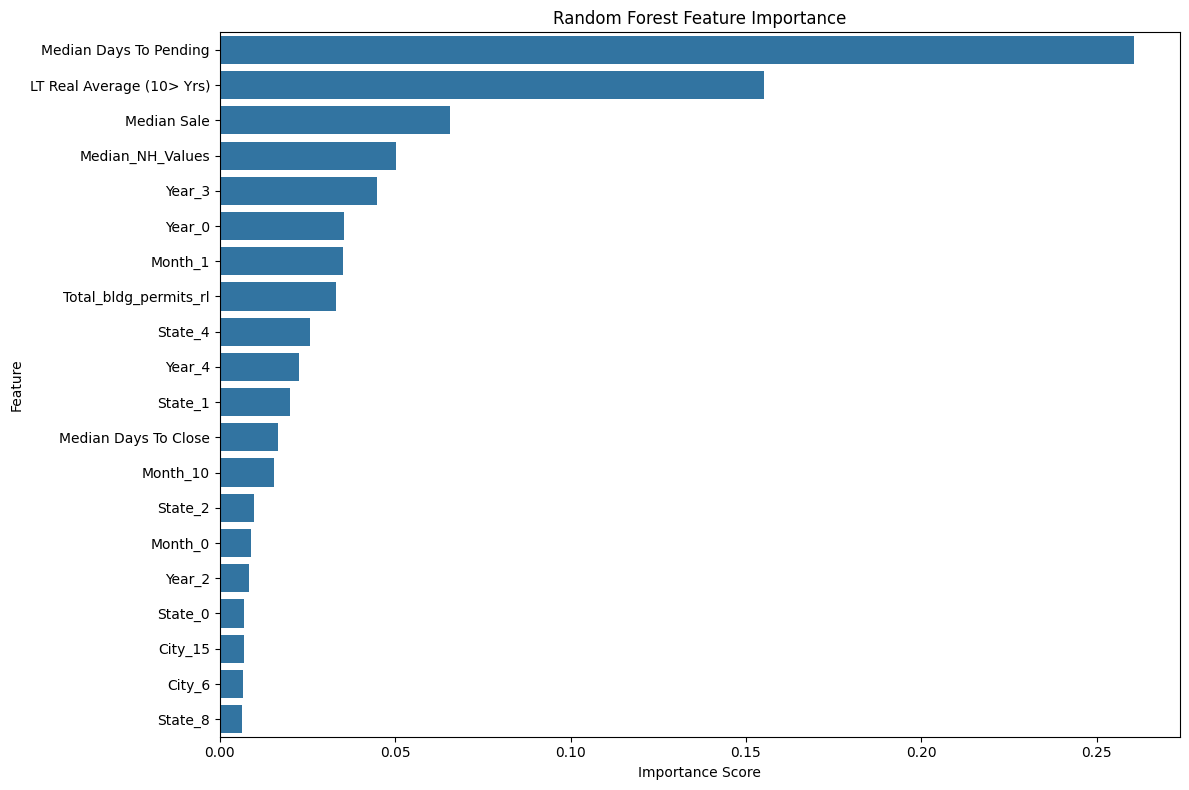


Top 10 Most Important Features:
                  Feature  Importance
   Median Days To Pending    0.260702
LT Real Average (10> Yrs)    0.155104
              Median Sale    0.065510
         Median_NH_Values    0.050156
                   Year_3    0.044697
                   Year_0    0.035518
                  Month_1    0.035102
    Total_bldg_permits_rl    0.033211
                  State_4    0.025849
                   Year_4    0.022491


In [ ]:
# 3. Train and evaluate models

print("\n===== Training Models =====")
model = base_model['Random Forest']
model_name = base_model['Random Forest']

print(f"\nTraining {model_name}...")

pipeline = Pipeline(stages=[
    label_indexer,
    *indexers,
    *encoders,
    numeric_assembler,
    scaler,
    final_assembler,
    model
])

fitted_pipeline = pipeline.fit(train_data)
val_predictions = fitted_pipeline.transform(val_data)

# Debug: Print schema of predictions DataFrame
print("\nPredictions DataFrame Schema:")
val_predictions.printSchema()

# Debug: Show a few rows of probability column
print("\nSample Probability Values:")
val_predictions.select("probability").show(5, truncate=False)

evaluation_results = evaluate_model_performance(val_predictions, model_name)
base_model[model_name] = {
    'model': fitted_pipeline,
    'evaluation': evaluation_results
}

print(f"\n==== {model_name} Evaluation Results ====")

print("\nPerformance Metrics by Class:")
print("----------------------------------------")
print(evaluation_results['metrics'].to_string(index=False))

print("\nConfusion Matrix:")
print("----------------------------------------")
if evaluation_results['confusion_matrix'] is not None:
  print("\nActual (rows) vs Predicted (columns):")
  print(evaluation_results['confusion_matrix'])

  print("\nClass Labels:")
  for idx, label in enumerate(evaluation_results['class_labels']):
      print(f"Class {idx}: {label}")

print("\nROC AUC Scores by Class:")
print("----------------------------------------")
for class_idx, auc_score in evaluation_results['roc_curves']['roc_auc'].items():
  if auc_score is not None:
      class_label = evaluation_results['class_labels'][class_idx]
      print(f"Class {class_label}: {auc_score:.3f}")

print("\nFeature Importance:")
print("----------------------------------------")
print("\nPipeline stages:")
for i, stage in enumerate(fitted_pipeline.stages):
    print(f"Stage {i}: {type(stage).__name__}")
importance_df = plot_feature_importance(fitted_pipeline, categorical_cols, numerical_cols)
if importance_df is not None:
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))

In [ ]:
def create_model_comparison_plots(all_results):
    """
    Create comparison visualizations between Random Forest and Logistic Regression including confusion matrices
    """
    # 1. Confusion Matrices Comparison
    plt.figure(figsize=(15, 6))

    for idx, (model_name, results) in enumerate(all_results['base_models'].items(), 1):
        plt.subplot(1, 2, idx)
        confusion_matrix = results['evaluation']['confusion_matrix']
        class_labels = results['evaluation']['class_labels']

        sns.heatmap(confusion_matrix,
                   annot=True,
                   fmt='g',
                   cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels)

        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 2. Overall Metrics Comparison
    plt.figure(figsize=(15, 10))

    comparison_data = []
    for model_name, results in all_results['base_models'].items():
        metrics_df = results['evaluation']['metrics']
        metrics_df['Model'] = model_name
        comparison_data.append(metrics_df)

    comparison_df = pd.concat(comparison_data)

    metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x='Model', y=metric, data=comparison_df)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 3. Per-Class Metric Comparison
    plt.figure(figsize=(15, 6))
    metrics_melted = comparison_df.melt(id_vars=['Class', 'Model'],
                                      value_vars=['Precision', 'Recall', 'F1-Score', 'ROC AUC'],
                                      var_name='Metric', value_name='Score')

    sns.barplot(x='Class', y='Score', hue='Model', data=metrics_melted, ci=None)
    plt.title('Model Performance Comparison by Class')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    # 4. ROC Curves Comparison
    plt.figure(figsize=(15, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results['base_models']) * 5))
    color_idx = 0

    for model_name, results in all_results['base_models'].items():
        roc_curves = results['evaluation']['roc_curves']
        class_labels = results['evaluation']['class_labels']

        for i, label in enumerate(class_labels):
            if i in roc_curves['fpr'] and len(roc_curves['fpr'][i]) > 0:
                plt.plot(roc_curves['fpr'][i],
                        roc_curves['tpr'][i],
                        color=colors[color_idx],
                        label=f'{model_name} - {label} (AUC={roc_curves["roc_auc"][i]:.3f})')
                color_idx += 1

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Print Summary Statistics
    print("\nModel Performance Summary:")
    print("=" * 50)

    for metric in ['Precision', 'Recall', 'F1-Score', 'ROC AUC']:
        print(f"\n{metric} Statistics:")
        print("-" * 30)
        summary = comparison_df.groupby('Model')[metric].agg(['mean', 'std', 'min', 'max'])
        print(summary.round(3))

    # 6. Print Per-Class Comparison
    print("\nPer-Class Performance Comparison:")
    print("=" * 50)

    for class_name in comparison_df['Class'].unique():
        print(f"\nClass: {class_name}")
        print("-" * 30)
        class_data = comparison_df[comparison_df['Class'] == class_name]
        for metric in ['Precision', 'Recall', 'F1-Score', 'ROC AUC']:
            print(f"\n{metric}:")
            for model in class_data['Model'].unique():
                value = class_data[class_data['Model'] == model][metric].iloc[0]
                print(f"{model}: {value:.3f}")

# Call the comparison function
# create_model_comparison_plots(all_results)

## Naive Bayes Modeling

In [ ]:
def evaluate_multiple_model_performances(predictions, model_name):
    """Evaluate model performance and prepare visualization data with improved error handling"""
    try:
        predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
        metrics = MulticlassMetrics(predictionAndLabels)

        confusion_matrix = metrics.confusionMatrix().toArray()

        try:
            label_indexer_model = [stage for stage in predictions.schema["label"].metadata["ml_attr"]["vals"]]
        except (KeyError, AttributeError):
            label_indexer_model = [float(x[0]) for x in predictions.select("label").distinct().collect()]
            label_indexer_model.sort()

        try:
            pred_pd = predictions.select("label", "probability").toPandas()

            # Extracting probabilities from vector column here
            probabilities = np.array([x.toArray() for x in pred_pd['probability']])
            n_classes = probabilities.shape[1]

            for i in range(n_classes):
                pred_pd[f'probability_{i}'] = probabilities[:, i]

            # Preparing data for ROC curves
            y_test = label_binarize(pred_pd['label'].values, classes=range(n_classes))

            roc_data = {'fpr': {}, 'tpr': {}, 'roc_auc': {}}

            for i in range(n_classes):
                try:
                    fpr, tpr, _ = roc_curve(y_test[:, i], probabilities[:, i])
                    roc_auc = auc(fpr, tpr)
                    roc_data['fpr'][i] = fpr
                    roc_data['tpr'][i] = tpr
                    roc_data['roc_auc'][i] = roc_auc
                except Exception as e:
                    print(f"Warning: Could not calculate ROC curve for class {i}: {str(e)}")
                    roc_data['fpr'][i] = []
                    roc_data['tpr'][i] = []
                    roc_data['roc_auc'][i] = None

        except Exception as e:
            print(f"Warning: Error calculating ROC curves for {model_name}: {str(e)}")
            roc_data = {'fpr': {}, 'tpr': {}, 'roc_auc': {}}

        # CAlculating metrics with error handling
        class_metrics = []
        for i, label in enumerate(label_indexer_model):
            try:
                metrics_dict = {
                    'Class': label,
                    'Precision': metrics.precision(float(i)),
                    'Recall': metrics.recall(float(i)),
                    'F1-Score': metrics.fMeasure(float(i))
                }
                if i in roc_data['roc_auc'] and roc_data['roc_auc'][i] is not None:
                    metrics_dict['ROC AUC'] = roc_data['roc_auc'][i]
                class_metrics.append(metrics_dict)
            except Exception as e:
                print(f"Warning: Could not calculate metrics for class {label}: {str(e)}")
                metrics_dict = {
                    'Class': label,
                    'Precision': None,
                    'Recall': None,
                    'F1-Score': None
                }
                class_metrics.append(metrics_dict)

        metrics_df = pd.DataFrame(class_metrics)

        return {
            'confusion_matrix': confusion_matrix,
            'class_labels': label_indexer_model,
            'roc_curves': roc_data,
            'metrics': metrics_df
        }

    except Exception as e:
        print(f"Error in evaluation for {model_name}: {str(e)}")
        return {
            'confusion_matrix': None,
            'class_labels': None,
            'roc_curves': {'fpr': {}, 'tpr': {}, 'roc_auc': {}},
            'metrics': pd.DataFrame()
        }

In [ ]:
from pyspark.ml.feature import MinMaxScaler

base_models = {}
base_models = {
    "Naive Bayes": (NaiveBayes(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        smoothing=1.0
    ), MinMaxScaler),

    "Logistic Regression": (LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=100,
        predictionCol="prediction",
        probabilityCol="probability"
    ), StandardScaler),

    "Random Forest": (RandomForestClassifier(
        featuresCol="features",
        labelCol="label",
        numTrees=100,
        maxDepth=10,
        seed=42,
        predictionCol="prediction",
        probabilityCol="probability"
    ), StandardScaler)


}

# Modified training loop to handle different scalers
print("\n===== Training Base Models =====")
for model_name, (model, scaler_class) in base_models.items():
    print(f"\nTraining {model_name}...")

    if issubclass(scaler_class, StandardScaler):  # Changed from isinstance to issubclass
        scaler = scaler_class(
            inputCol="numerical_features",
            outputCol="scaled_numerical_features",
            withStd=True,
            withMean=True
        )
    if issubclass(scaler_class, MinMaxScaler):  # Separate condition for MinMaxScaler
        scaler = scaler_class(
            inputCol="numerical_features",
            outputCol="scaled_numerical_features",
            min=0.0,
            max=1.0
        )

    pipeline = Pipeline(stages=[
        label_indexer,
        *indexers,
        *encoders,
        numeric_assembler,
        scaler,
        final_assembler,
        model
    ])

    fitted_pipeline = pipeline.fit(train_data)
    val_predictions = fitted_pipeline.transform(val_data)
    evaluation_results = evaluate_multiple_model_performances(val_predictions, model_name)
    all_results['base_models'][model_name] = {
        'model': fitted_pipeline,
        'evaluation': evaluation_results
    }


===== Training Base Models =====

Training Naive Bayes...


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Training Random Forest...


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
def create_model_comparison_plots(all_results):
    """
    Create comparison visualizations between Logistic Regression, Random Forest, and Naive Bayes
    including ROC curves
    """
    plt.figure(figsize=(20, 6))

    for idx, (model_name, results) in enumerate(all_results['base_models'].items(), 1):
        plt.subplot(1, 3, idx)
        confusion_matrix = results['evaluation']['confusion_matrix']
        class_labels = results['evaluation']['class_labels']

        sns.heatmap(confusion_matrix,
                   annot=True,
                   fmt='g',
                   cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels)

        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Overall Metrics Comparison
    plt.figure(figsize=(15, 8))

    comparison_data = []
    for model_name, results in all_results['base_models'].items():
        metrics_df = results['evaluation']['metrics']
        metrics_df['Model'] = model_name
        comparison_data.append(metrics_df)

    comparison_df = pd.concat(comparison_data)

    metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x='Model', y=metric, data=comparison_df)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Per-Class Metric Comparison
    plt.figure(figsize=(15, 6))
    metrics_melted = comparison_df.melt(id_vars=['Class', 'Model'],
                                      value_vars=['Precision', 'Recall', 'F1-Score', 'ROC AUC'],
                                      var_name='Metric', value_name='Score')

    sns.barplot(x='Class', y='Score', hue='Model', data=metrics_melted, ci=None)
    plt.title('Model Performance Comparison by Class')
    plt.xticks(rotation=45)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # ROC Curves Comparison
    plt.figure(figsize=(15, 8))

    n_models = len(all_results['base_models'])
    n_classes = len(next(iter(all_results['base_models'].values()))['evaluation']['class_labels'])
    colors = plt.cm.tab10(np.linspace(0, 1, n_models * n_classes))
    color_idx = 0

    # Plotting ROC curves for each model and class
    for model_name, results in all_results['base_models'].items():
        roc_curves = results['evaluation']['roc_curves']
        class_labels = results['evaluation']['class_labels']

        for i, label in enumerate(class_labels):
            if i in roc_curves['fpr'] and len(roc_curves['fpr'][i]) > 0:
                plt.plot(roc_curves['fpr'][i],
                        roc_curves['tpr'][i],
                        color=colors[color_idx],
                        label=f'{model_name} - {label} (AUC={roc_curves["roc_auc"][i]:.3f})')
                color_idx += 1

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary Statistics are printed here
    print("\nModel Performance Summary:")
    print("=" * 50)

    for metric in ['Precision', 'Recall', 'F1-Score', 'ROC AUC']:
        print(f"\n{metric} Statistics:")
        print("-" * 30)
        summary = comparison_df.groupby('Model')[metric].agg(['mean', 'std', 'min', 'max'])
        print(summary.round(3))

    print("\nPer-Class Performance Comparison:")
    print("=" * 50)

    for class_name in comparison_df['Class'].unique():
        print(f"\nClass: {class_name}")
        print("-" * 30)
        class_data = comparison_df[comparison_df['Class'] == class_name]
        for metric in ['Precision', 'Recall', 'F1-Score', 'ROC AUC']:
            print(f"\n{metric}:")
            for model in class_data['Model'].unique():
                value = class_data[class_data['Model'] == model][metric].iloc[0]
                print(f"{model}: {value:.3f}")


==== Naive Bayes Evaluation Results ====

Performance Metrics by Class:
----------------------------------------
         Class  Precision   Recall  F1-Score  ROC AUC
 buyers market   0.636147 0.736915  0.682833 0.874099
neutral market   0.582550 0.571053  0.576744 0.765478
sellers market   0.774495 0.670256  0.718615 0.894737

Confusion Matrix:
----------------------------------------

Actual (rows) vs Predicted (columns):
[[535. 159.  32.]
 [213. 434. 113.]
 [ 93. 152. 498.]]

Class Labels:
Class 0: buyers market
Class 1: neutral market
Class 2: sellers market

==== Logistic Regression Evaluation Results ====

Performance Metrics by Class:
----------------------------------------
         Class  Precision   Recall  F1-Score  ROC AUC
 buyers market   0.821716 0.844353  0.832880 0.960920
neutral market   0.748336 0.739474  0.743878 0.900880
sellers market   0.889344 0.876178  0.882712 0.973031

Confusion Matrix:
----------------------------------------

Actual (rows) vs Predicted (col

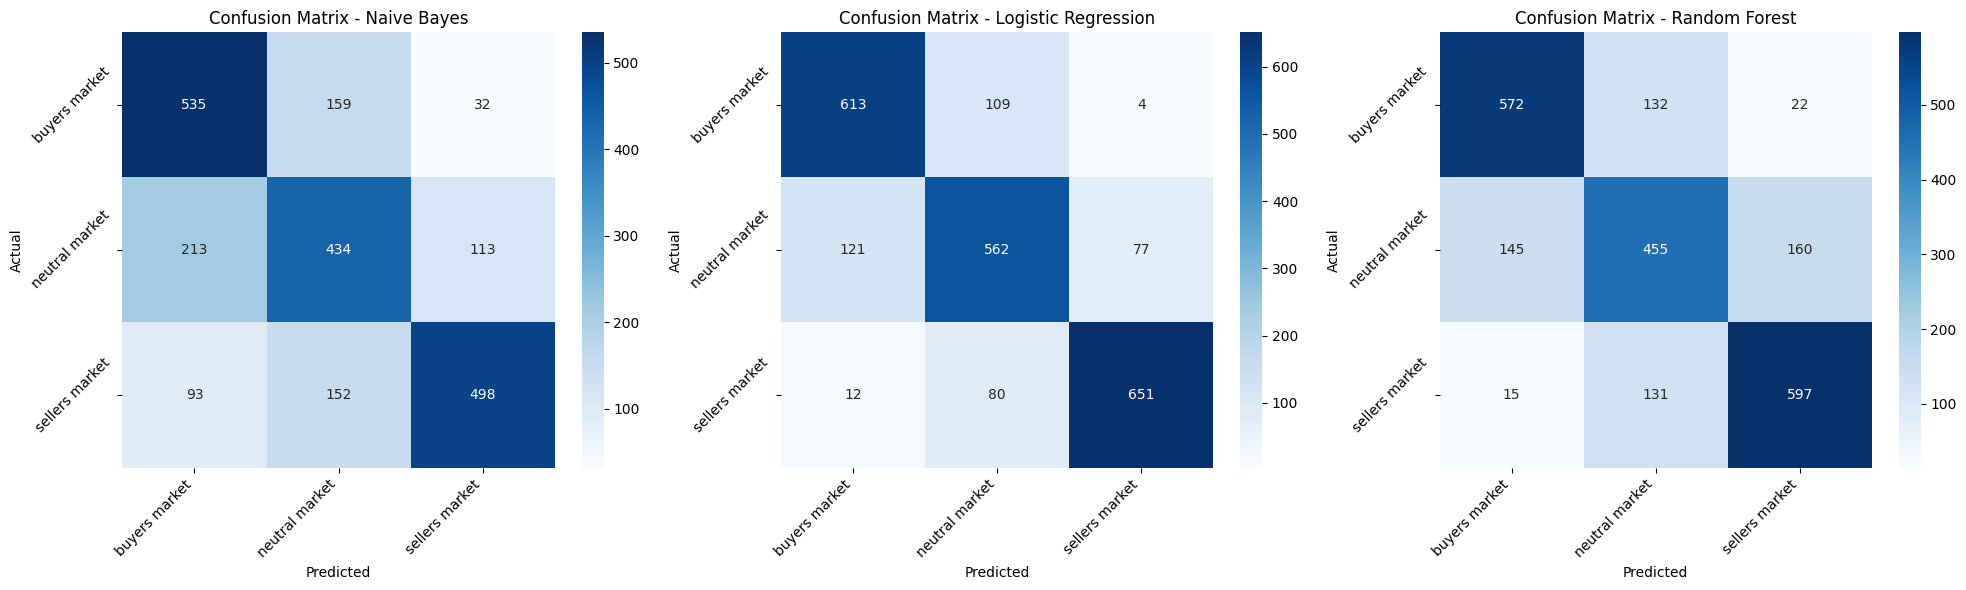

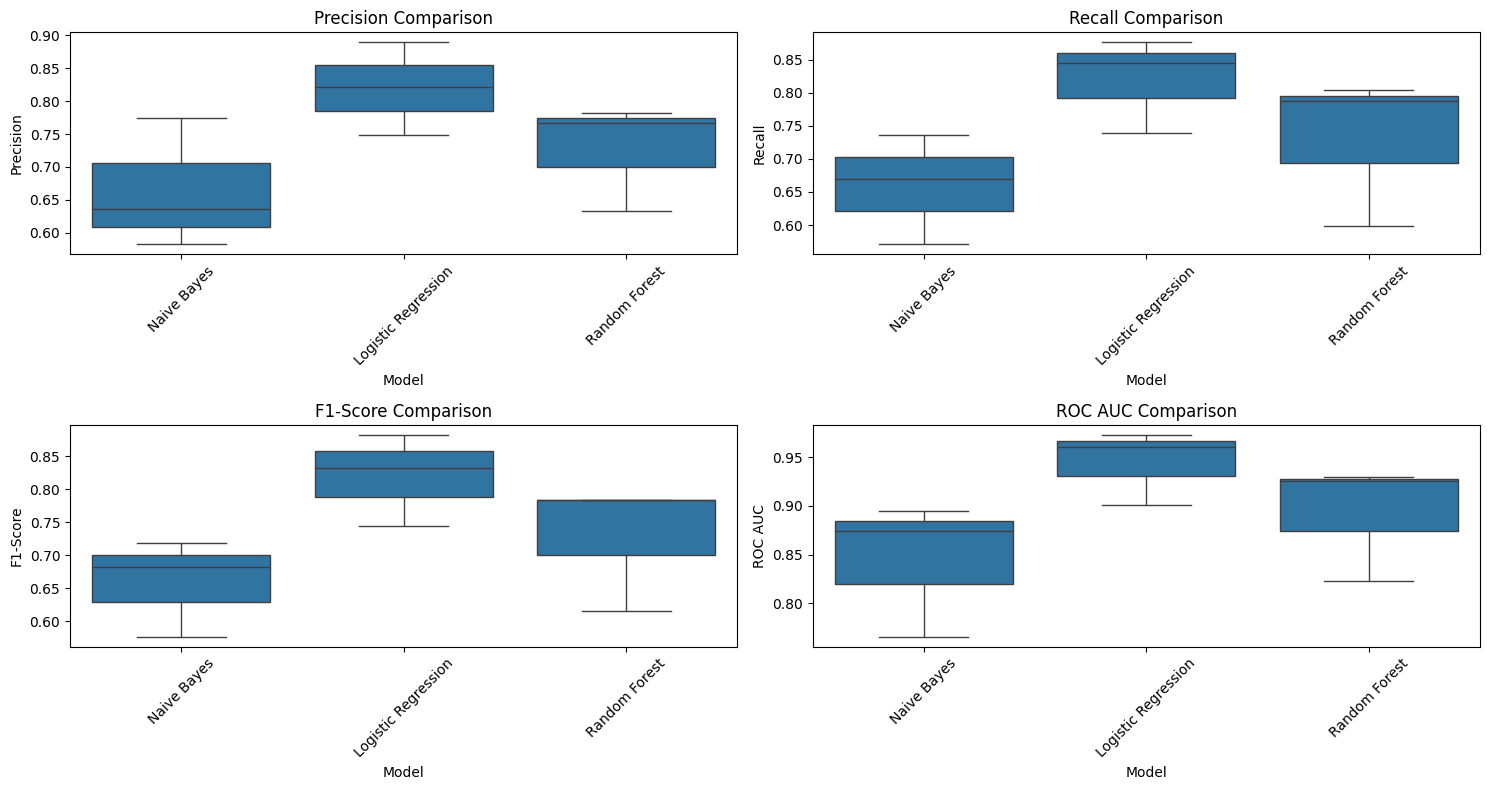

<ipython-input-24-23e8b237a126>:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Class', y='Score', hue='Model', data=metrics_melted, ci=None)


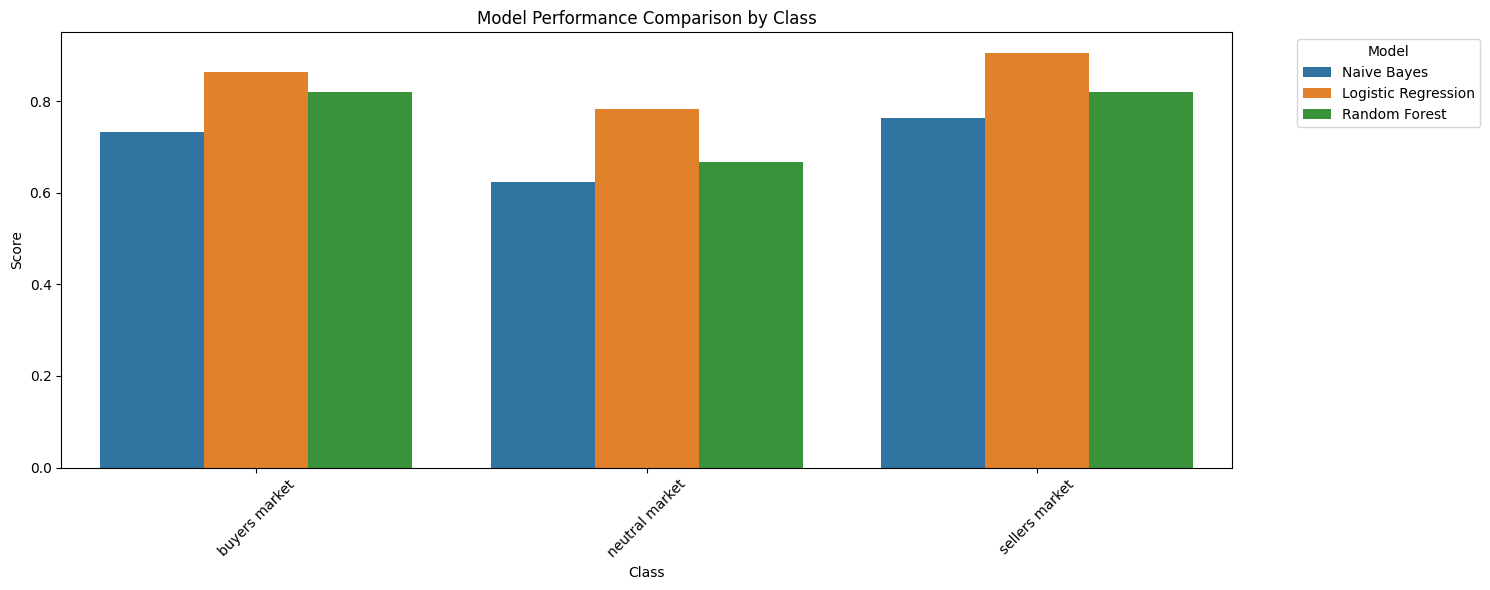

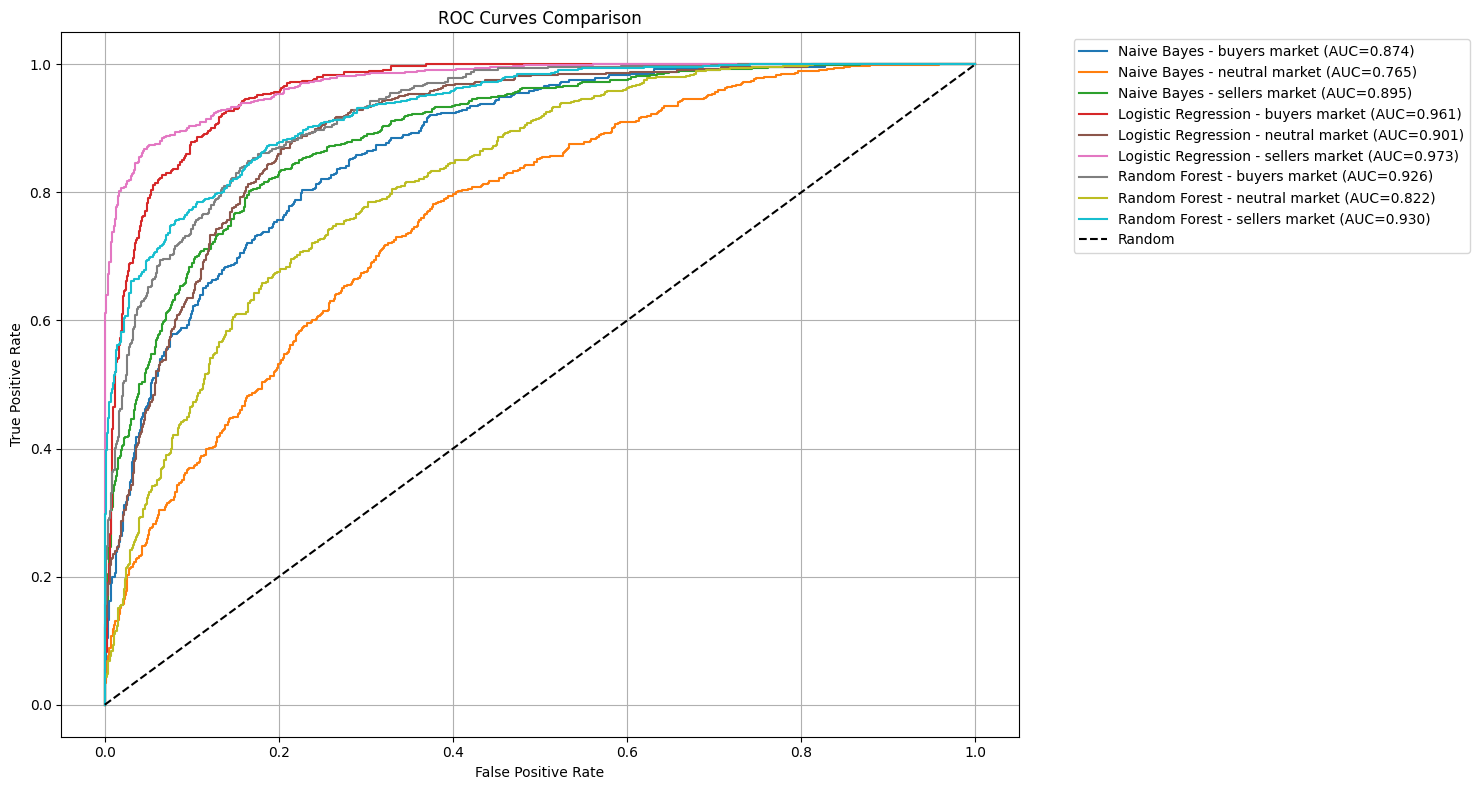


Model Performance Summary:

Precision Statistics:
------------------------------
                      mean    std    min    max
Model                                          
Logistic Regression  0.820  0.071  0.748  0.889
Naive Bayes          0.664  0.099  0.583  0.774
Random Forest        0.727  0.081  0.634  0.781

Recall Statistics:
------------------------------
                      mean    std    min    max
Model                                          
Logistic Regression  0.820  0.072  0.739  0.876
Naive Bayes          0.659  0.083  0.571  0.737
Random Forest        0.730  0.114  0.599  0.803

F1-Score Statistics:
------------------------------
                      mean    std    min    max
Model                                          
Logistic Regression  0.820  0.070  0.744  0.883
Naive Bayes          0.659  0.074  0.577  0.719
Random Forest        0.728  0.097  0.616  0.785

ROC AUC Statistics:
------------------------------
                      mean    std    min  

In [ ]:
# Print detailed results for each model
for model_name in all_results['base_models']:
    print(f"\n==== {model_name} Evaluation Results ====")

    results = all_results['base_models'][model_name]['evaluation']

    print("\nPerformance Metrics by Class:")
    print("----------------------------------------")
    print(results['metrics'].to_string(index=False))

    print("\nConfusion Matrix:")
    print("----------------------------------------")
    if results['confusion_matrix'] is not None:
        print("\nActual (rows) vs Predicted (columns):")
        print(results['confusion_matrix'])

        print("\nClass Labels:")
        for idx, label in enumerate(results['class_labels']):
            print(f"Class {idx}: {label}")

print("\nGenerating comparison plots...")
create_model_comparison_plots(all_results)

In [ ]:
val_predictions.show()

+-----+----------+-----+----+--------+--------------------+----------------------+------------------------+-----------+------------------+-------------------------+----------------------+---------------------+--------------+-----+-----------+----------+-----------+----------+---------------+-----------------+--------------+-------------+--------------------+-------------------------+--------------------+--------------------+--------------------+----------+
|State|      City|Month|Year|SizeRank|Median Days To Close|Median Days To Pending|Market Temp Index Values|Median Sale|  Median_NH_Values|LT Real Average (10> Yrs)|Number of failed banks|Total_bldg_permits_rl| market_nature|label|State_Index|City_Index|Month_Index|Year_Index|      State_Vec|         City_Vec|     Month_Vec|     Year_Vec|  numerical_features|scaled_numerical_features|            features|       rawPrediction|         probability|prediction|
+-----+----------+-----+----+--------+--------------------+-------------------

In [ ]:
train_data = train_data.withColumn(
    'Year',
    col('Year').cast(StringType())
)

test_data = test_data.withColumn(
    'Year',
    col('Year').cast(StringType())
)

label_indexer = StringIndexer(inputCol="market_nature", outputCol="label")
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_Vec") for col in categorical_cols]
numeric_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features",
    handleInvalid="skip"
)
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)
final_assembler = VectorAssembler(
    inputCols=["scaled_numerical_features"] + [f"{col}_Vec" for col in categorical_cols],
    outputCol="features"
)

model_name = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=100,
        predictionCol="prediction",
        probabilityCol="probability"
    )

pipeline = Pipeline(stages=[
        label_indexer,
        *indexers,
        *encoders,
        numeric_assembler,
        scaler,
        final_assembler,
        model_name
    ])

param_grid = ParamGridBuilder().addGrid(model_name.regParam, [1.0, 2.0]).build()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
cv = CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 3)
cv_model = cv.fit(train_data)
cv_predictions = cv_model.transform(test_data)
print("\nEvaluation Scores Cross_val model")
print("----------------------------------------")
evaluation_values = evaluator.evaluate(cv_predictions)
print("AUC-ROC Curve:", evaluation_values)


Evaluation Scores Cross_val model
----------------------------------------
AUC-ROC Curve: 0.722374341762229


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

# Ensure that 'market_nature' and other categorical columns don't have null values. Need it for cross_validation
train_data = train_data.withColumn("market_nature", when(col("market_nature").isNull(), "unknown").otherwise(col("market_nature")))

for cat_col in categorical_cols:
    train_data = train_data.withColumn(cat_col, when(col(cat_col).isNull(), "unknown").otherwise(col(cat_col)))

label_indexer = StringIndexer(
    inputCol="market_nature",
    outputCol="label",
    handleInvalid="keep"
)

indexers = [StringIndexer(
    inputCol=col,
    outputCol=f"{col}_Index",
    handleInvalid="keep"
) for col in categorical_cols]

encoders = [OneHotEncoder(inputCol=f"{col}_Index", outputCol=f"{col}_Vec") for col in categorical_cols]

numeric_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features",
    handleInvalid="skip"
)

scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)

final_assembler = VectorAssembler(
    inputCols=["scaled_numerical_features"] + [f"{col}_Vec" for col in categorical_cols],
    outputCol="features"
)

model_name = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    predictionCol="prediction",
    probabilityCol="probability"
)

pipeline = Pipeline(stages=[
    label_indexer,
    *indexers,
    *encoders,
    numeric_assembler,
    scaler,
    final_assembler,
    model_name
])

param_grid = ParamGridBuilder().addGrid(model_name.regParam, [1.0, 2.0]).build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=1  # Adding this argument to see results sequentially
)

print("Starting cross-validation...")
cv_model = cv.fit(train_data)

print("\nCross-validation metrics:")
accuracies = cv_model.avgMetrics
for i, accuracy in enumerate(accuracies):
    print(f"Param set {i+1} average accuracy across folds: {accuracy:.4f}")

cv_predictions = cv_model.transform(test_data)

test_accuracy = evaluator.evaluate(cv_predictions)
print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")

best_model_index = np.argmax(accuracies)
print(f"\nBest performing model (Param Set {best_model_index + 1}):")
print(f"RegParam: {param_grid[best_model_index].get(model_name.regParam)}")
print(f"Average Accuracy: {accuracies[best_model_index]:.4f}")


Starting cross-validation...


KeyboardInterrupt: 

The code above takes a while to run. The average cross validation score is 0.7281. This is lower than our overall accuracy from the confusion matrix indicating slight overfitting.